IMPORTS

In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import sklearn.linear_model as lm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from itertools import chain, combinations
import warnings
warnings.filterwarnings(action='ignore')
sns.set_style('darkgrid')

%matplotlib inline

In [198]:
df = pd.read_csv('data/kc_house_data.csv', index_col=0) # (30155,25), 3 duplicated entries
# display(df.head())
# print("Deleted Duplicate Entries:")
# display(df.loc[df.duplicated(keep=False)])
df.drop_duplicates(inplace=True)


# Helper Functions

In [199]:
# OLS
def get_train_score(xtrain, ytrain):
    lr = lm.LinearRegression()
    lr.fit(xtrain, ytrain)
    return lr.score(xtrain, ytrain)

def get_adjusted_train_score(xtrain, ytrain):
    # test R-Squared
    R2 = get_train_score(xtrain,ytrain)
    # number of observations in test data
    n = xtrain.shape[0]
    # number of features in test data (including constant)
    k = xtrain.shape[1] + 1
    return 1 - ( (1-R2) * ( (n-1)/(n-k-1 ) ) )

def get_test_score(xtrain, ytrain, xtest, ytest):
    lr = lm.LinearRegression()
    lr.fit(xtrain, ytrain)
    return lr.score(xtest, ytest)

# Adjusted R2 = 1 – [(1-R2)*(n-1)/(n-k-1)]
def get_adjusted_test_score(xtrain, ytrain, xtest, ytest):
    # test R-Squared
    R2 = get_test_score(xtrain,ytrain,xtest,ytest)
    # number of observations in test data
    n = xtest.shape[0]
    # number of features in test data (including constant)
    k = xtest.shape[1] + 1
    return 1 - ( (1-R2) * ( (n-1)/(n-k-1 ) ) )

def print_train_scores(xtrain, ytrain):
    print(f"         Train R2: {get_train_score(xtrain, ytrain)}")
    print(f"Train Adjusted R2: {get_train_score(xtrain, ytrain)}")

def print_test_scores(xtrain, ytrain, xtest, ytest):
    print(f"         Test R2: {get_test_score(xtrain, ytrain, xtest, ytest)}")
    print(f"Test Adjusted R2: {get_test_score(xtrain, ytrain, xtest, ytest)}")


# RIDGE
def get_train_score_ridge(xtrain, ytrain):
    rr = lm.Ridge()
    rr.fit(xtrain, ytrain)
    return rr.score(xtrain, ytrain)

def get_adjusted_train_score(xtrain, ytrain):
    # test R-Squared
    R2 = get_train_score_ridge(xtrain,ytrain)
    # number of observations in test data
    n = xtrain.shape[0]
    # number of features in test data (including constant)
    k = xtrain.shape[1] + 1
    return 1 - ( (1-R2) * ( (n-1)/(n-k-1 ) ) )

def get_test_score_ridge(xtrain, ytrain, xtest, ytest):
    rr = lm.Ridge()
    rr.fit(xtrain, ytrain)
    return rr.score(xtest, ytest)


def get_adjusted_test_score_ridge(xtrain, ytrain, xtest, ytest):
    # test R-Squared
    R2 = get_test_score(xtrain,ytrain,xtest,ytest)
    # number of observations in test data
    n = xtest.shape[0]
    # number of features in test data (including constant)
    k = xtest.shape[1] + 1
    return 1 - ( (1-R2) * ( (n-1)/(n-k-1 ) ) )

def print_train_scores_ridge(xtrain, ytrain):
    print(f"         Train R2: {get_train_score_ridge(xtrain, ytrain)}")
    print(f"Train Adjusted R2: {get_train_score_ridge(xtrain, ytrain)}")

def print_test_scores_ridge(xtrain, ytrain, xtest, ytest):
    print(f"         Test R2: {get_test_score_ridge(xtrain, ytrain, xtest, ytest)}")
    print(f"Test Adjusted R2: {get_test_score_ridge(xtrain, ytrain, xtest, ytest)}")







def scale_custom(xtrain, xtest, col_names):
    # normally scale regularly distributed columns
    scaler = StandardScaler()
    custom_xtrain = pd.DataFrame(data=scaler.fit_transform(xtrain.drop(columns=col_names)),
                                 index=xtrain.index,
                                 columns=[col for col in xtrain.columns if col not in col_names])
    custom_xtest = pd.DataFrame(data=scaler.transform(xtest.drop(columns=col_names)),
                                index=xtest.index,
                                columns=[col for col in xtest.columns if col not in col_names])

    # custom scale irregularly distributed columns
    bad_xtrain = xtrain[col_names]
    bad_xtest = xtest[col_names]
    for col in col_names:
        true_xtrain = bad_xtrain.loc[bad_xtrain[col] != 0][col]
        xtrain_true_mean = true_xtrain.mean()
        xtrain_true_std = true_xtrain.std()
        custom_xtrain[col] = bad_xtrain[col].apply(lambda x: 0 if x == 0 else (x - xtrain_true_mean) / xtrain_true_std)
        custom_xtest[col] = bad_xtest[col].apply(lambda x: 0 if x == 0 else (x - xtrain_true_mean) / xtrain_true_std)

    return (custom_xtrain, custom_xtest)
    
def powerset(col_names, num_cols_lower_bound):
    "powerset([1,2,3]) --> (1,2) (1,3) (2,3) (1,2,3)"
    s = list(col_names)
    return list(list(subset) for subset in chain.from_iterable(combinations(s, r) for r in range(len(s)+1)) if len(list(subset)) > num_cols_lower_bound)


# Numeric Correlations to Price

In [35]:
# Only numeric features, no nans, no duplicates
numeric_df = df.select_dtypes([int,float])
# OUTLIER, 1 sqft and 4 bathrooms
numeric_df.drop(index=1549500215, inplace=True)
# drop lat, long which become zipcode
numeric_df.drop(columns=['lat','long'], inplace=True)

# substitute sqft_home
# numeric_df["sqft_home"] = (numeric_df['sqft_above'] + numeric_df['sqft_basement'] + numeric_df['sqft_garage'] + numeric_df['sqft_patio'])
# numeric_df = numeric_df.drop(columns=["sqft_above", "sqft_basement", "sqft_garage", "sqft_patio"])

# fix columns order
bad_cols = ['sqft_basement','sqft_garage', 'sqft_patio','yr_renovated']
reg_cols = [col for col in numeric_df.columns.to_list() if col not in bad_cols]
numeric_df = numeric_df[reg_cols + bad_cols]

numeric_df.head()


display(numeric_df.head())
display(numeric_df.info())
display(numeric_df.describe(percentiles=[.05,.25,.5,.75,.95]))

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                         
7399300360  675000.0         4        1.0         1180      7140     1.0   
8910500230  920000.0         5        2.5         2770      6703     1.0   
1180000275  311000.0         6        2.0         2880      6156     1.0   
1604601802  775000.0         3        3.0         2160      1400     2.0   
8562780790  592500.0         2        2.0         1120       758     2.0   

            sqft_above  yr_built  sqft_basement  sqft_garage  sqft_patio  \
id                                                                         
7399300360        1180      1969              0            0          40   
8910500230        1570      1950           1570            0         240   
1180000275        1580      1956           1580            0           0   
1604601802        1090      2010           1070          200         270   
8562780790        1120      2012            550          550          30   

            yr_renovated  
id                        
7399300360             0  
8910500230             0  
1180000275             0  
1604601802             0  
8562780790             0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30151 entries, 7399300360 to 9557800100
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          30151 non-null  float64
 1   bedrooms       30151 non-null  int64  
 2   bathrooms      30151 non-null  float64
 3   sqft_living    30151 non-null  int64  
 4   sqft_lot       30151 non-null  int64  
 5   floors         30151 non-null  float64
 6   sqft_above     30151 non-null  int64  
 7   yr_built       30151 non-null  int64  
 8   sqft_basement  30151 non-null  int64  
 9   sqft_garage    30151 non-null  int64  
 10  sqft_patio     30151 non-null  int64  
 11  yr_renovated   30151 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 3.0 MB


None

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  3.015100e+04  30151.000000  30151.000000  30151.000000  3.015100e+04   
mean   1.108006e+06      3.413552      2.334616   2112.478691  1.671464e+04   
std    8.946335e+05      0.981663      0.889511    973.993389  6.036006e+04   
min    2.736000e+04      0.000000      0.000000    100.000000  4.020000e+02   
5%     4.250000e+05      2.000000      1.000000    940.000000  1.196000e+03   
25%    6.480000e+05      3.000000      2.000000   1420.000000  4.850000e+03   
50%    8.600000e+05      3.000000      2.500000   1920.000000  7.480000e+03   
75%    1.300000e+06      4.000000      3.000000   2619.500000  1.057900e+04   
95%    2.500000e+06      5.000000      4.000000   3890.000000  4.573800e+04   
max    3.075000e+07     13.000000     10.500000  15360.000000  3.253932e+06   

             floors    sqft_above      yr_built  sqft_basement   sqft_garage  \
count  30151.000000  30151.000000  30151.000000   30151.000000  30151.000000   
mean       1.543365   1809.899307   1975.158071     476.026566    330.238334   
std        0.567618    878.278036     32.065421     579.638258    285.768874   
min        1.000000    100.000000   1900.000000       0.000000      0.000000   
5%         1.000000    830.000000   1916.000000       0.000000      0.000000   
25%        1.000000   1180.000000   1953.000000       0.000000      0.000000   
50%        1.500000   1560.000000   1977.000000       0.000000    400.000000   
75%        2.000000   2270.000000   2003.000000     940.000000    510.000000   
95%        2.000000   3460.000000   2021.000000    1500.000000    780.000000   
max        4.000000  12660.000000   2022.000000    8020.000000   3580.000000   

         sqft_patio  yr_renovated  
count  30151.000000  30151.000000  
mean     217.404066     90.934364  
std      245.310376    416.499347  
min        0.000000      0.000000  
5%         0.000000      0.000000  
25%       40.000000      0.000000  
50%      150.000000      0.000000  
75%      320.000000      0.000000  
95%      680.000000      0.000000  
max     4370.000000   2022.000000

### Train - Test Split

In [333]:
# numeric Train test split (.75 train, .25 test)
X_train, X_test, y_train, y_test = train_test_split(numeric_df.drop(columns='price'), numeric_df[['price']], test_size=.25, random_state=42)


In [ ]:
# NO PRICE OUTLIERs Train test split (.75 train, .25 test)
IQR = numeric_df['price'].quantile(.75) - numeric_df['price'].quantile(.25)
IQR_scaler = 1.5
price_outlier_bound = numeric_df['price'].quantile(.75) + IQR_scaler * IQR
no_outliers_df = numeric_df.loc[numeric_df['price'] < price_outlier_bound]
X_train, X_test, y_train, y_test = train_test_split(no_outliers_df.drop(columns='price'), no_outliers_df[['price']], test_size=.25, random_state=42)

### Test

In [213]:
xtrain, xtest = scale_custom(X_train, X_test, col_names=bad_cols)

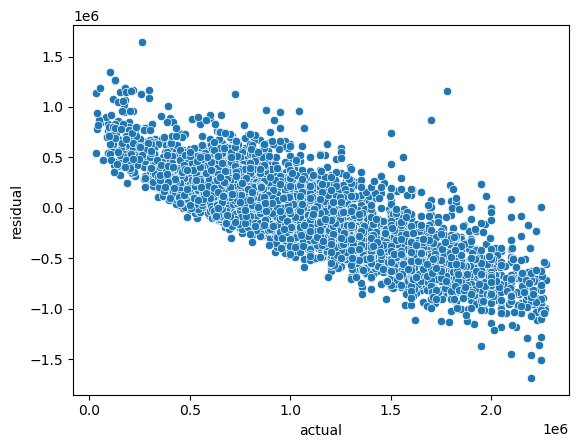

In [201]:
y_hat = lr.predict(xtest)
sns.scatterplot(x= y_test['price'],y= (y_hat - y_test)['price'].to_list()).set(xlabel='actual', ylabel='residual');

### Heatmap

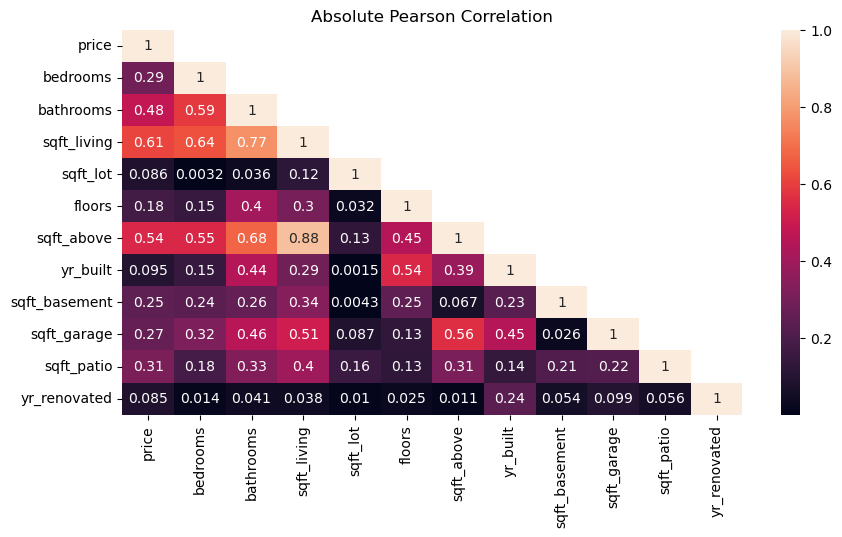

numeric abs(correlation) order: 
sqft_living      0.610040
sqft_above       0.540142
bathrooms        0.481183
sqft_patio       0.313659
bedrooms         0.290017
sqft_garage      0.265311
sqft_basement    0.245532
floors           0.179608
yr_built         0.095408
sqft_lot         0.085952
yr_renovated     0.085088
Name: price, dtype: float64


In [266]:
corr_df = numeric_df.corr().abs()

fig, ax = plt.subplots(figsize=(10,5))

mask = np.triu(np.ones_like(corr_df), k=1)
sns.heatmap(corr_df, annot=True, mask=mask, ax=ax).set(title='Absolute Pearson Correlation')

plt.show()
print("numeric abs(correlation) order: \n{}".format(corr_df['price'].sort_values(ascending=False)[1:]))

### PairPlots

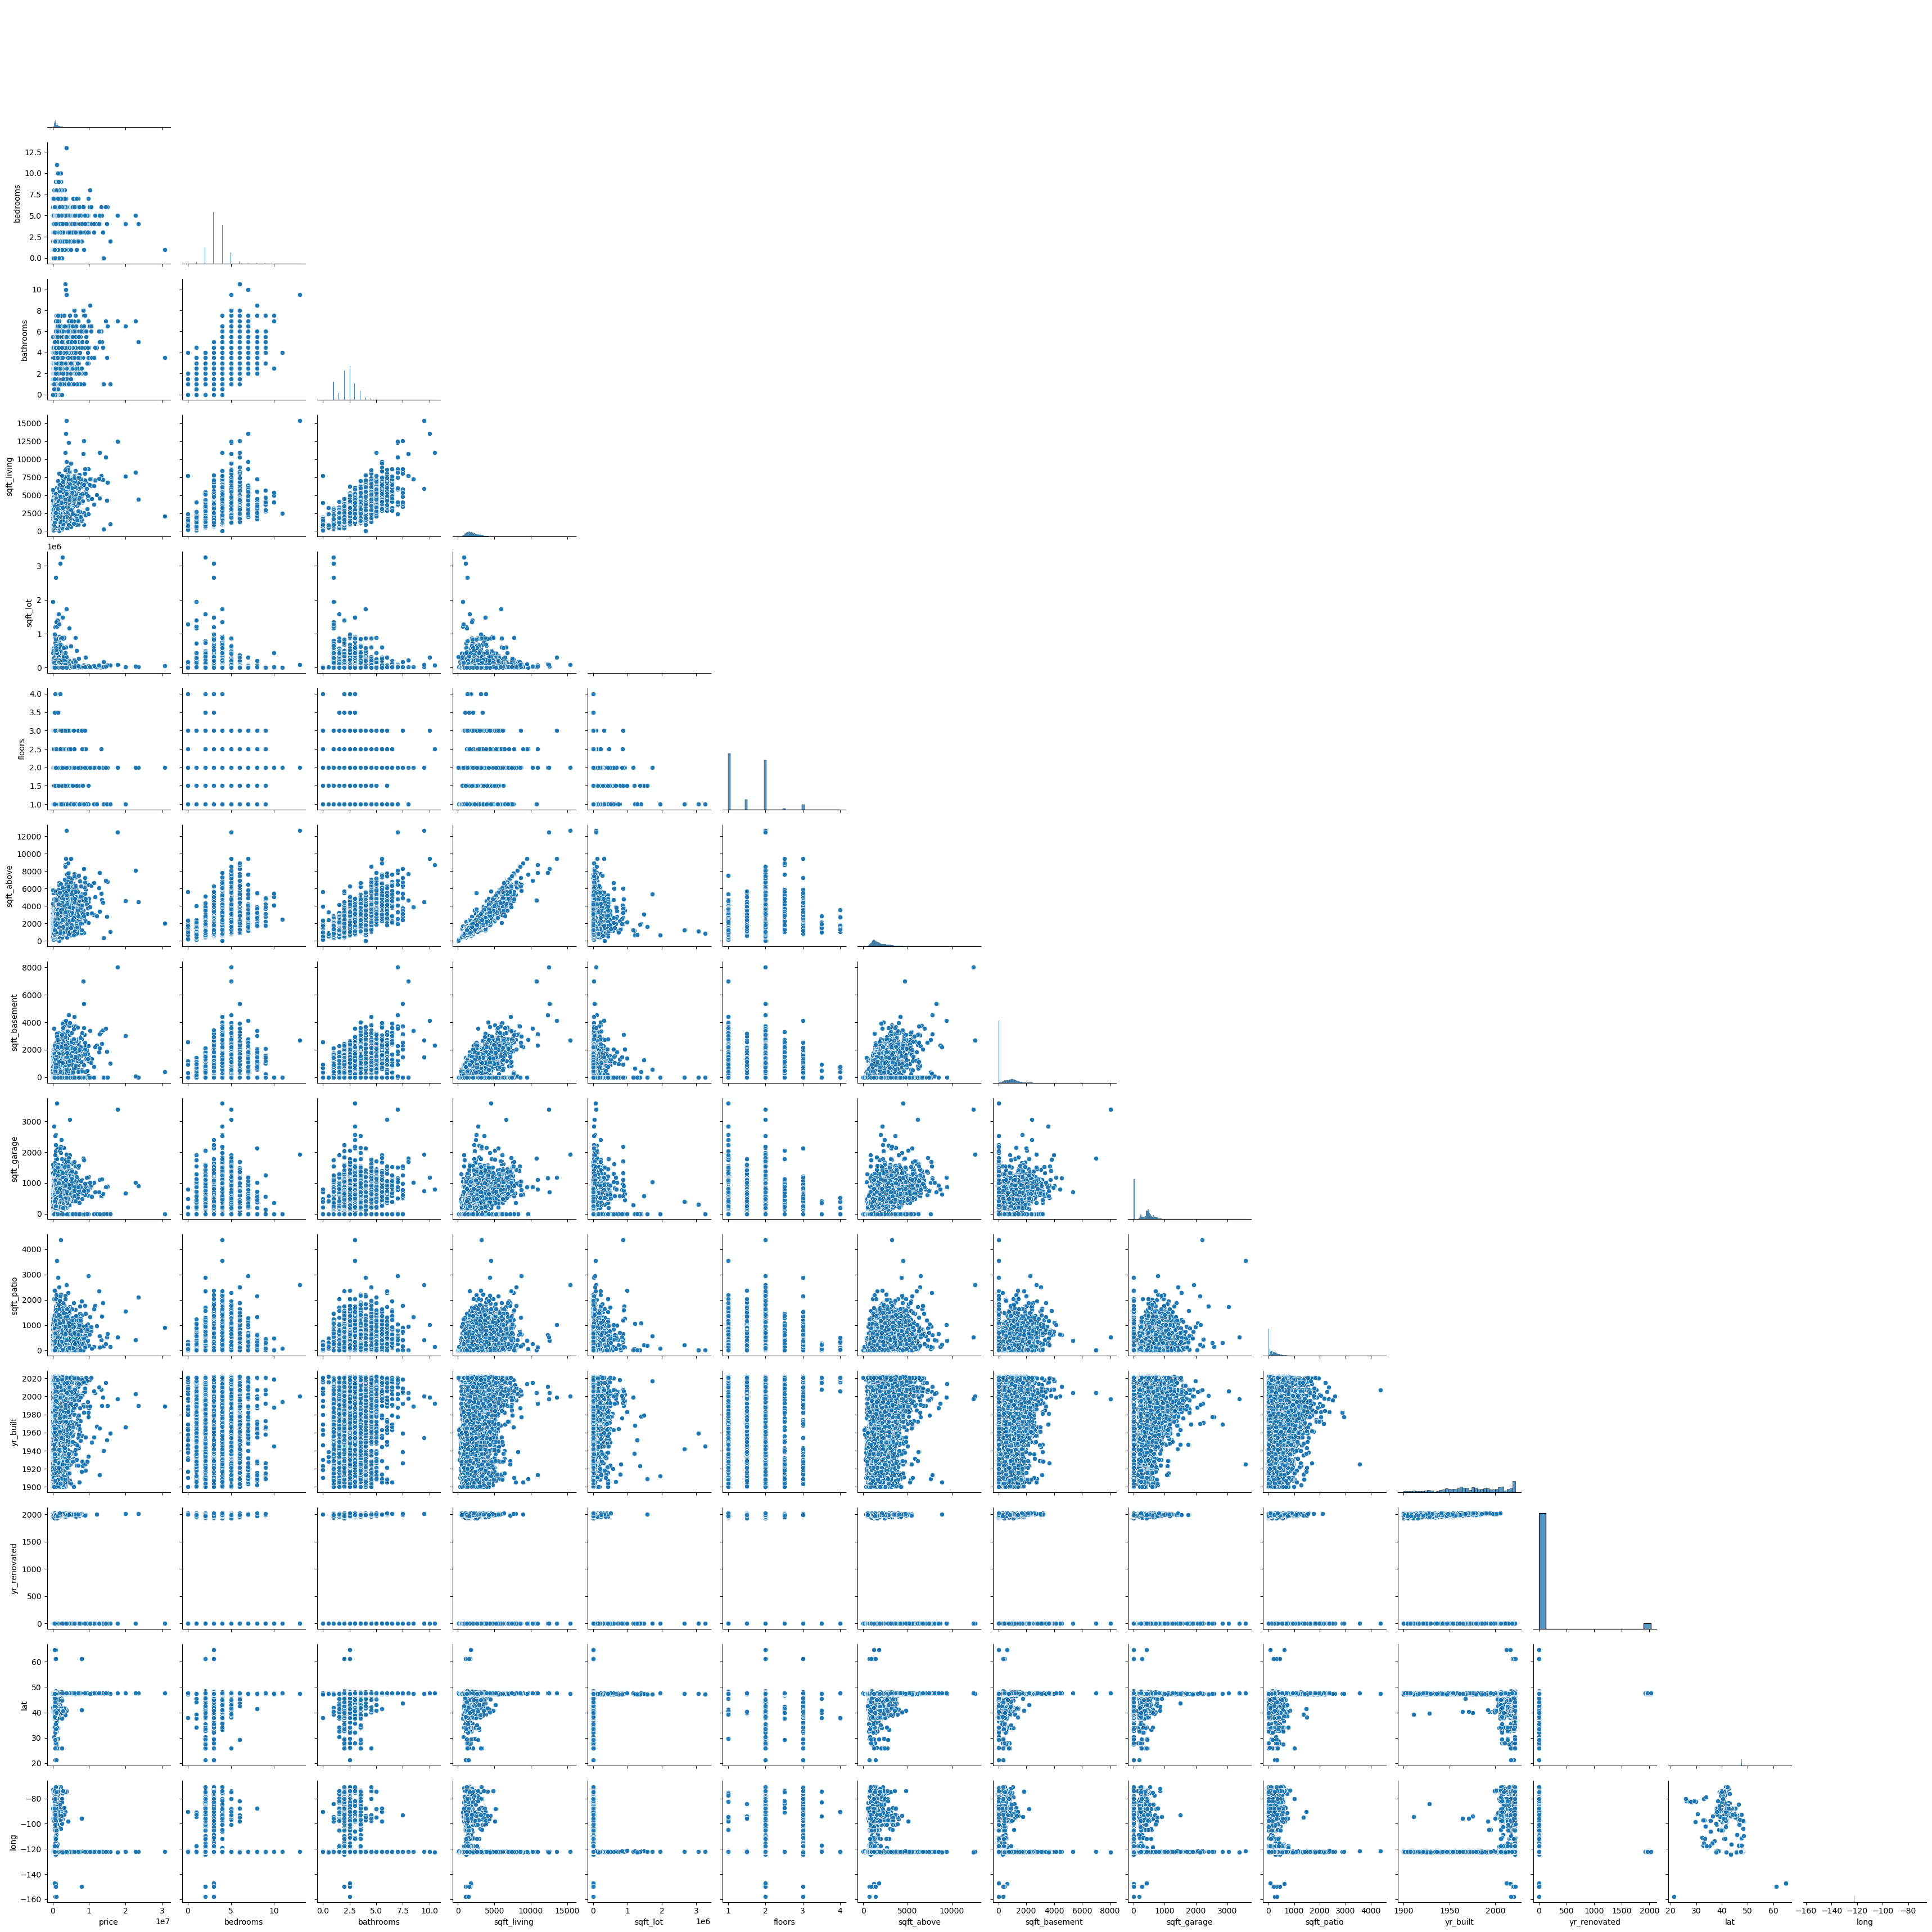

In [7]:
sns.pairplot(numeric_df, corner=True)
plt.show()

### Target Analysis

Target outliers overview
> log_Price and Price_no_outliers, have the most normal-like distributions

price outliers count: 1991


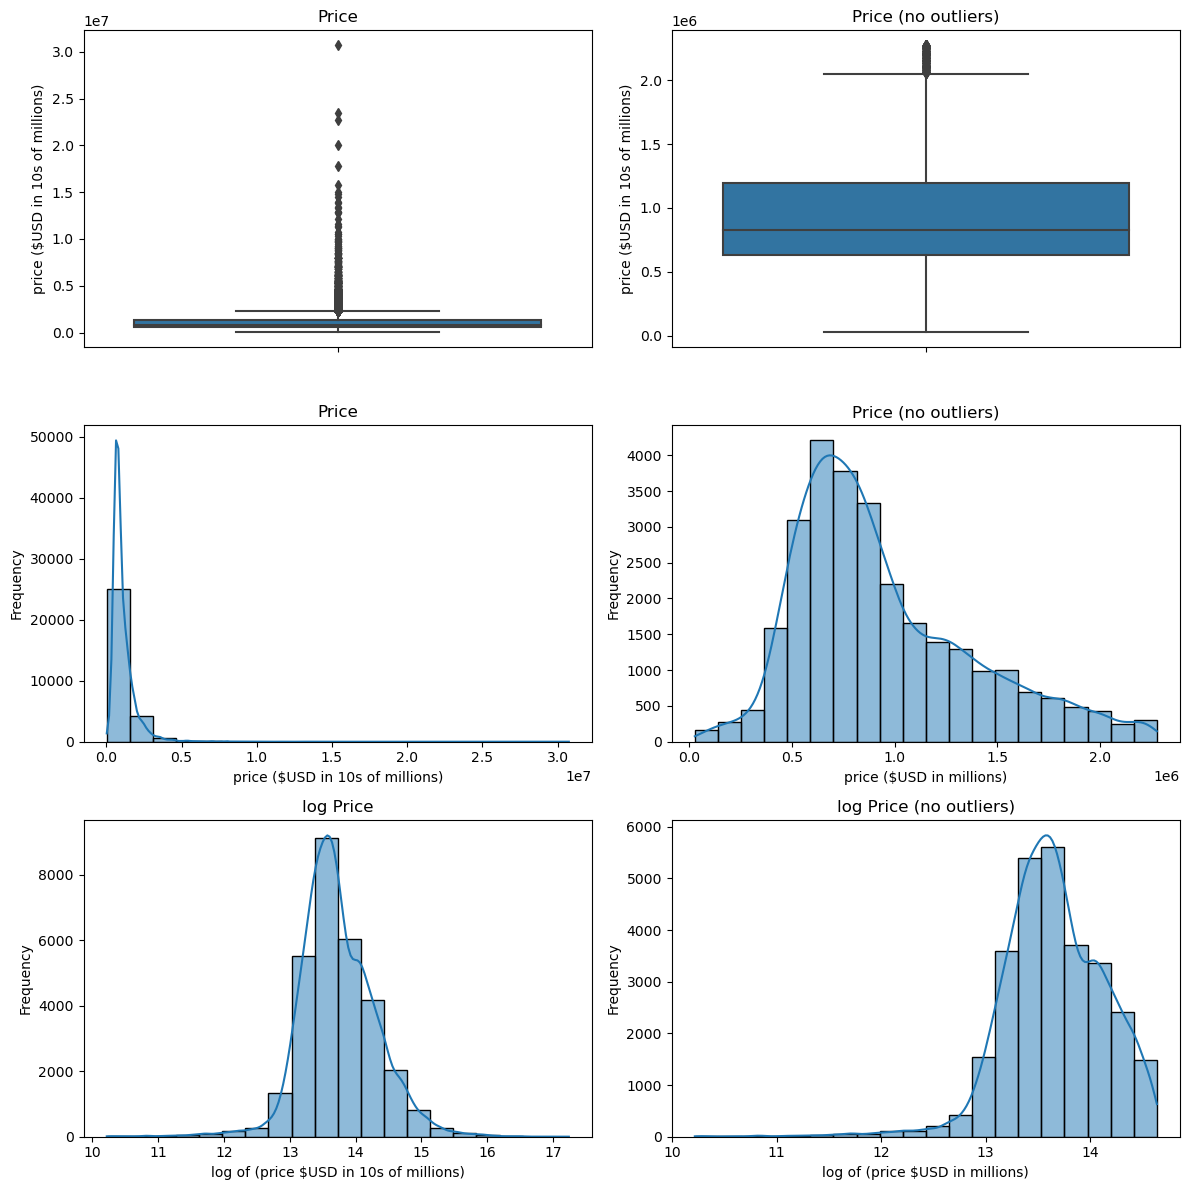

In [158]:
IQR = numeric_df['price'].quantile(.75) - numeric_df['price'].quantile(.25)
IQR_scaler = 1.5
price_outlier_bound = numeric_df['price'].quantile(.75) + IQR_scaler * IQR
price_no_outliers = numeric_df['price'].loc[numeric_df['price'] < price_outlier_bound]

fig, ax = plt.subplots(3,2, figsize = (12,12))
# boxplot of target
sns.boxplot(y=numeric_df['price'], ax=ax[0][0])
ax[0][0].set_title('Price')
ax[0][0].set_ylabel('price ($USD in 10s of millions)')
ax[0][0].set_xticklabels([])

# boxplot of target - target_outliers
sns.boxplot(y=price_no_outliers, ax=ax[0][1])
ax[0][1].set_title('Price (no outliers)')
ax[0][1].set_ylabel('price ($USD in 10s of millions)')
ax[0][1].set_xticklabels([])

# histogram of target
sns.histplot(numeric_df['price'], bins=20, kde=True, ax=ax[1][0])
ax[1][0].set_title('Price')
ax[1][0].set_ylabel('Frequency')
ax[1][0].set_xlabel('price ($USD in 10s of millions)')

# histogram of target - target_outliers
sns.histplot(price_no_outliers, bins=20, kde=True, ax=ax[1][1])
ax[1][1].set_title('Price (no outliers)')
ax[1][1].set_ylabel('Frequency')
ax[1][1].set_xlabel('price ($USD in millions)')

# histograms of log(target)
sns.histplot(np.log(numeric_df['price']), bins=20, kde=True, ax=ax[2][0])
ax[2][0].set_title('log Price')
ax[2][0].set_ylabel('Frequency')
ax[2][0].set_xlabel('log of (price $USD in 10s of millions)')

# histograms of log(target - target_outliers)
sns.histplot(np.log(price_no_outliers), bins=20, kde=True, ax=ax[2][1])
ax[2][1].set_title('log Price (no outliers)')
ax[2][1].set_ylabel('Frequency')
ax[2][1].set_xlabel('log of (price $USD in millions)')

print('price outliers count: {}'.format(numeric_df.shape[0] - price_no_outliers.shape[0]))
plt.tight_layout()
plt.show()

Target outlier Normality
> Log(Price_no_outliers) is less normally distributed than Price_no_outliers

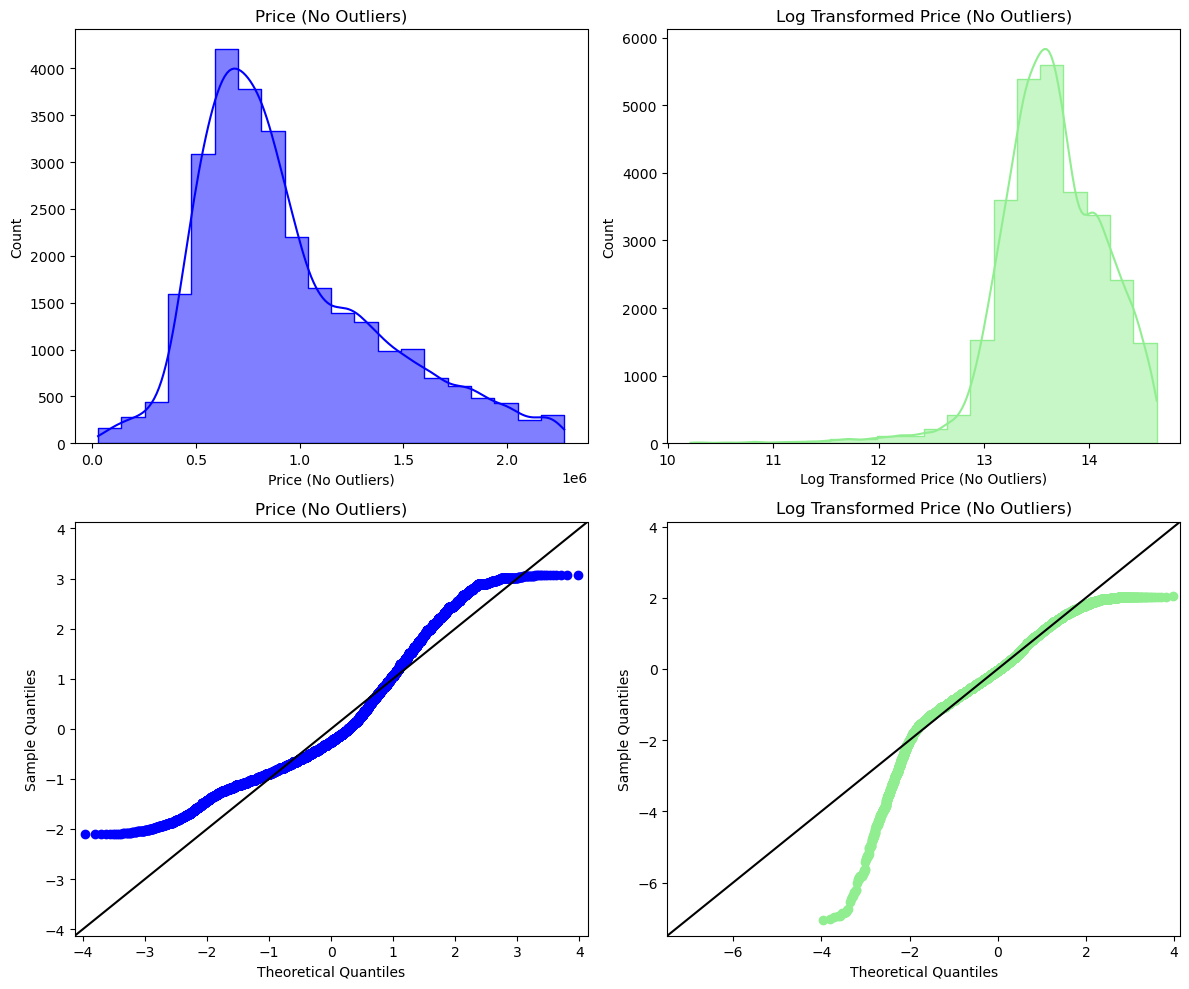

In [159]:
# Compare normality of target_no_outliers vs log_target_no_outliers

# Set up plot and properties of two targets
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
targets = [price_no_outliers, np.log(price_no_outliers)]
labels = ["Price (No Outliers)", "Log Transformed Price (No Outliers)"]
colors = ["blue", "lightgreen"]

# Plot histograms
for index, ax in enumerate(axes[0]):
    sns.histplot(targets[index], bins=20, element="step", kde=True, color=colors[index], ax=ax)
    ax.set_xlabel(labels[index])
    ax.set_title(labels[index])
    
# Plot Q-Q plots
for index, ax in enumerate(axes[1]):
    sm.graphics.qqplot(targets[index], dist=stats.norm, line='45', fit=True, ax=ax)
    scatter = ax.lines[0]
    line = ax.lines[1]
    scatter.set_markeredgecolor(colors[index])
    scatter.set_markerfacecolor(colors[index])
    line.set_color("black")
    ax.set_title(labels[index])
    
fig.tight_layout()

Target Normality
> Log(Price) is more normally distributed than Price

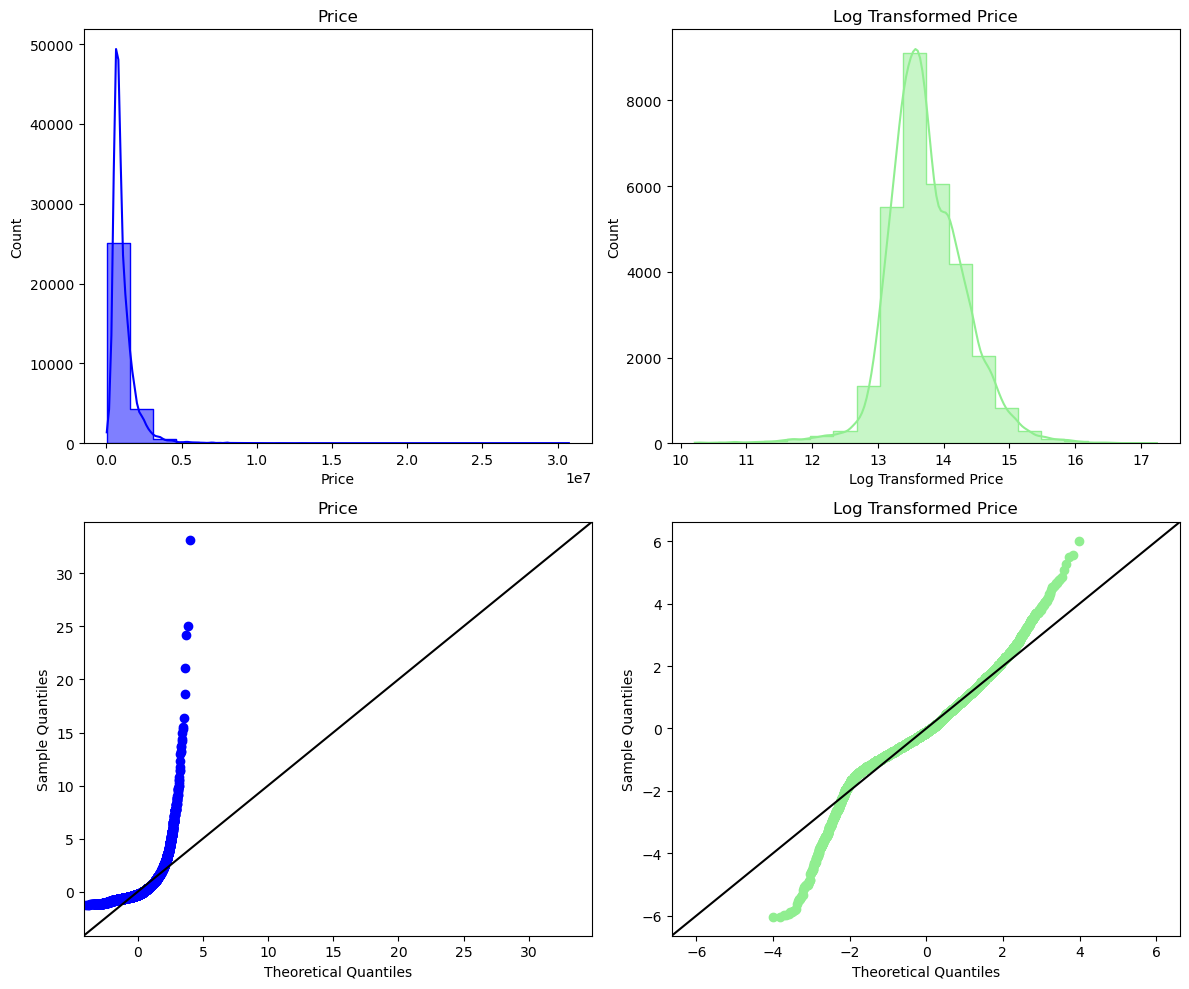

In [160]:
# Compare normality of target vs log_target

# Set up plot and properties of two targets
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
targets = [numeric_df['price'], np.log(numeric_df['price'])]
labels = ["Price", "Log Transformed Price"]
colors = ["blue", "lightgreen"]

# Plot histograms
for index, ax in enumerate(axes[0]):
    sns.histplot(targets[index], bins=20, element="step", kde=True, color=colors[index], ax=ax)
    ax.set_xlabel(labels[index])
    ax.set_title(labels[index])
    
# Plot Q-Q plots
for index, ax in enumerate(axes[1]):
    sm.graphics.qqplot(targets[index], dist=stats.norm, line='45', fit=True, ax=ax)
    scatter = ax.lines[0]
    line = ax.lines[1]
    scatter.set_markeredgecolor(colors[index])
    scatter.set_markerfacecolor(colors[index])
    line.set_color("black")
    ax.set_title(labels[index])
    
fig.tight_layout()

### Intercept only model

> STATS  
>
> R2 = 0  
> MAE  = $1,223,166,877,958.95  
> RMSE = $1,223,166,877,959.26  
> MSE  = $1.4961372113366093e+24

In [162]:
# y = y_train, X = mean(y_train) 
y = y_train
X = np.ones(len(y)).reshape(-1,1)

# fit model and display statistics
intercept_only_model = sm.OLS(y,X)
intercept_only_results = intercept_only_model.fit()
intercept_only_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 14 Feb 2023   Prob (F-statistic):                nan
Time:                        15:47:48   Log-Likelihood:            -3.4222e+05
No. Observations:               22614   AIC:                         6.844e+05
Df Residuals:                   22613   BIC:                         6.844e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.106e+06   6007.991    184.083      0.000    1.09e+06    1.12e+06
==============================================================================
Omnibus:                    29672.143   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14077510.865
Skew:                           7.067   Prob(JB):                         0.00
Kurtosis:                     124.411   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
# get MAE, RMSE, and MSE
y_bar = intercept_only_results.params.values[0]
y_hat = intercept_only_results.predict(np.array([y_bar] * len(y_test))).reshape(-1,1)
intercept_only_mae = metrics.mean_absolute_error(y_test, y_hat)
intercept_only_rmse = metrics.mean_squared_error(y_test, y_hat, squared=False)
intercept_only_mse = metrics.mean_squared_error(y_test, y_hat)
intercept_only_mae, intercept_only_rmse, intercept_only_mse

(1223166877958.955, 1223166877959.263, 1.4961372113366106e+24)

## Feature Normality Comparisons
> scaling feature after log transformation is bad  
> log transformation is more normal than raw feature

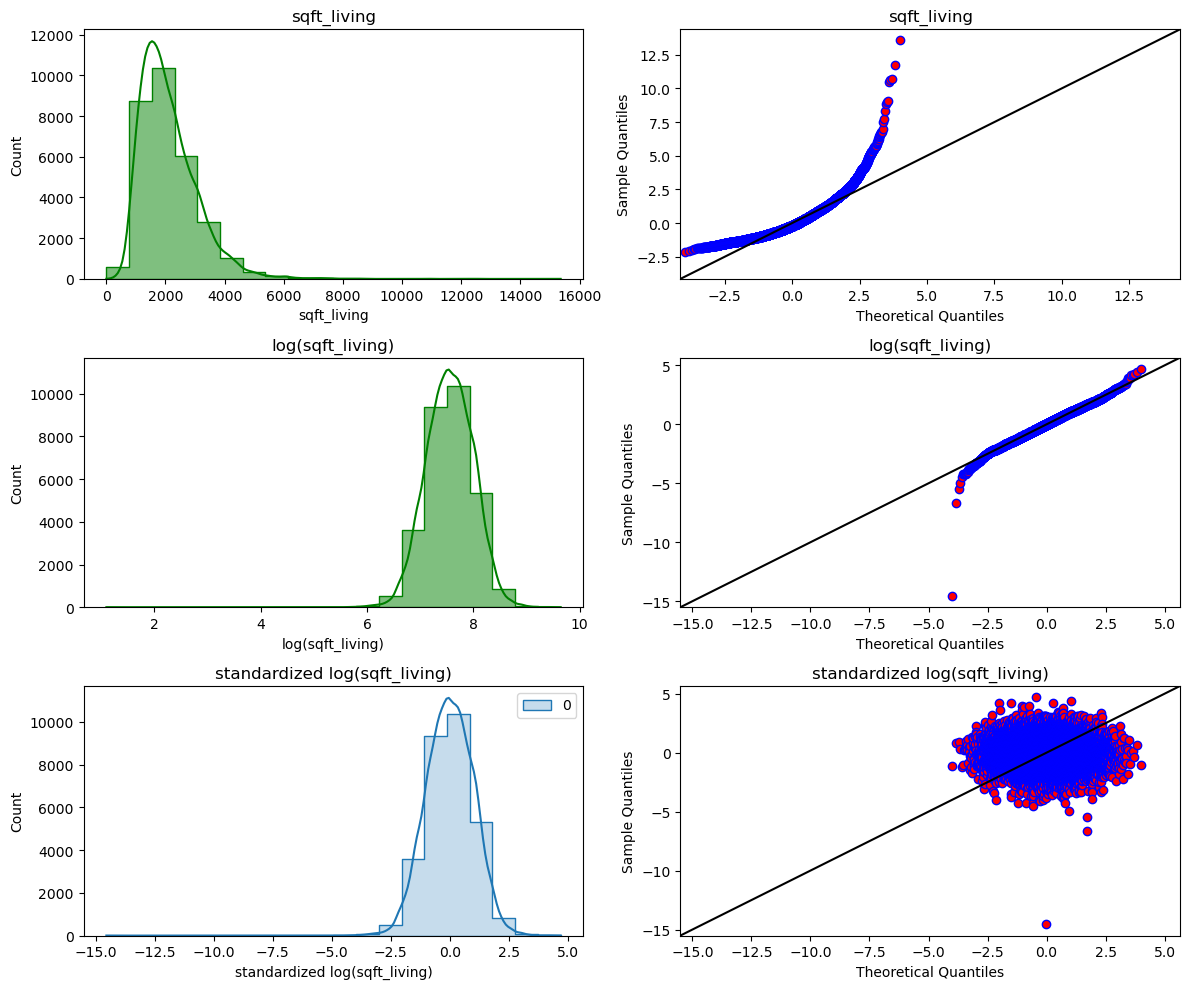

In [164]:
# Compare normality of feature vs log_feature vs scaled_log_feature

# set standard scaler
scaler = StandardScaler()

# Set up plot and properties of two targets
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10))
targets = [numeric_df['sqft_living'], np.log(numeric_df['sqft_living']), scaler.fit_transform(np.log(numeric_df[['sqft_living']]))]
labels = ['sqft_living','log(sqft_living)','standardized log(sqft_living)']

for index, ax in enumerate(axes):
    #plot histograms
    sns.histplot(targets[index], bins=20, element="step", color='green', kde=True, ax=ax[0])
    ax[0].set_xlabel(labels[index])
    ax[0].set_title(labels[index])

    #plot qq plots
    sm.graphics.qqplot(targets[index], dist=stats.norm, line='45', fit=True, ax=ax[1])
    scatter = ax[1].lines[0]
    line = ax[1].lines[1]
    scatter.set_markeredgecolor('blue')
    scatter.set_markerfacecolor('red')
    line.set_color("black")
    ax[1].set_title(labels[index])
    
fig.tight_layout()

## Baseline Model iterations

### Baseline Model
using `sqft_living` - Square footage of living space in the home

> STATS  
>
> R2 = .357  
> MAE  = $387,075.97  
> RMSE = $660,279.79  
> MSE  = $435,969,410,152.92

In [210]:
# y = training house prices, X = training sqft_living
y = y_train
X = X_train['sqft_living']

# fit model and display statistics
baseline_model = sm.OLS(y,sm.add_constant(X))
baseline_results = baseline_model.fit()
baseline_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.256e+04
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:59:38   Log-Likelihood:            -3.3722e+05
No. Observations:               22614   AIC:                         6.744e+05
Df Residuals:                   22612   BIC:                         6.745e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.084e+04   1.16e+04     -6.131      0.000   -9.35e+04   -4.82e+04
sqft_living   558.4585      4.984    112.056      0.000     548.690     568.227
==============================================================================
Omnibus:                    34088.874   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         46345812.743
Skew:                           8.916   Prob(JB):                         0.00
Kurtosis:                     224.062   Cond. No.                     5.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [212]:
# get baseline_model MAE, RMSE, and MSE
y_hat = baseline_results.predict(sm.add_constant(X_test[['sqft_living']])).values.reshape(-1,1)
baseline_mae = metrics.mean_absolute_error(y_test, y_hat)
baseline_rmse = metrics.mean_squared_error(y_test, y_hat, squared=False)
baseline_mse = metrics.mean_squared_error(y_test, y_hat)
baseline_mae, baseline_rmse, baseline_mse

(387075.9715188813, 660279.7968686641, 435969410152.92426)

### Baseline Model Standardized Feature
using scaled `sqft_living` - Square footage of living space in the home  

> STATS  
>
> R2 = .357  
> MAE  = $387,075.97  
> RMSE = $660,279.79  
> MSE  = $435,969,410,152.92

In [229]:
# Scale train and test feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['sqft_living']])
X_test_scaled = scaler.transform(X_test[['sqft_living']])

# y = training house prices, X = scaled training sqft_living
y = y_train
X = X_train_scaled

# fit model and display statistics
baseline_scaled_model = sm.OLS(y,sm.add_constant(X))
baseline_scaled_results = baseline_scaled_model.fit()
print_test_scores(X,y,X_test_scaled,y_test)
baseline_scaled_results.summary()

         Test R2: 0.3539167706349541
Test Adjusted R2: 0.3539167706349541


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                 1.377e+04
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:08:49   Log-Likelihood:            -3.3643e+05
No. Observations:               22613   AIC:                         6.729e+05
Df Residuals:                   22611   BIC:                         6.729e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.107e+06   4654.528    237.779      0.000     1.1e+06    1.12e+06
x1          5.463e+05   4654.528    117.366      0.000    5.37e+05    5.55e+05
==============================================================================
Omnibus:                    28500.573   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11871192.848
Skew:                           6.573   Prob(JB):                         0.00
Kurtosis:                     114.474   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
# get baseline_model MAE, RMSE, and MSE
y_hat = baseline_scaled_results.predict(sm.add_constant(X_test_scaled)).reshape(-1,1)
baseline_scaled_mae = metrics.mean_absolute_error(y_test, y_hat)
baseline_scaled_rmse = metrics.mean_squared_error(y_test, y_hat, squared=False)
baseline_scaled_mse = metrics.mean_squared_error(y_test, y_hat)
baseline_scaled_mae, baseline_scaled_rmse, baseline_scaled_mse

(387075.9715188815, 660279.7968686641, 435969410152.92426)

### Baseline Model Standardized Feature, Log Transformed Target
using scaled `sqft_living` - Square footage of living space in the home  
using log transformed `price` target

> STATS (BEST)  
>
> R2 = .382  
> MAE  = $387,242.51  
> RMSE = $1,625,341.92  
> MSE  = $2,641,736,364,388.60

In [230]:
# Scale train and test feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['sqft_living']])
X_test_scaled = scaler.transform(X_test[['sqft_living']])

# Log transform train and test target
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

# y = training house prices, X = scaled training sqft_living
y = log_y_train
X = X_train_scaled

# fit model and display statistics
baseline_scaled_logTarget_model = sm.OLS(y,sm.add_constant(X))
baseline_scaled_logTarget_results = baseline_scaled_logTarget_model.fit()
print_test_scores(X,y,X_test_scaled,log_y_test)
baseline_scaled_logTarget_results.summary()

         Test R2: 0.38941723603652967
Test Adjusted R2: 0.38941723603652967


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                 1.423e+04
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:09:13   Log-Likelihood:                -14341.
No. Observations:               22613   AIC:                         2.869e+04
Df Residuals:                   22611   BIC:                         2.870e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7333      0.003   4526.292      0.000      13.727      13.739
x1             0.3619      0.003    119.269      0.000       0.356       0.368
==============================================================================
Omnibus:                     4403.908   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35841.441
Skew:                          -0.712   Prob(JB):                         0.00
Kurtosis:                       9.001   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [171]:
# get baseline_model MAE, RMSE, and MSE
y_hat = baseline_scaled_logTarget_results.predict(sm.add_constant(X_test_scaled)).reshape(-1,1)
baseline_scaled_logTarget_mae = metrics.mean_absolute_error(np.exp(log_y_test), np.exp(y_hat))
baseline_scaled_logTarget_rmse = metrics.mean_squared_error(np.exp(log_y_test), np.exp(y_hat), squared=False)
baseline_scaled_logTarget_mse = metrics.mean_squared_error(np.exp(log_y_test), np.exp(y_hat))
baseline_scaled_logTarget_mae, baseline_scaled_logTarget_rmse, baseline_scaled_logTarget_mse

(387242.51256115106, 1625341.922300848, 2641736364388.6157)

### Baseline Model Log Transformed feature
using log transformed `sqft_living` - Square footage of living space in the home  
using raw `price` target

> STATS  
>
> R2 = .254  
> MAE  = $420,664.09  
> RMSE = $723,247.70  
> MSE  = $523,087,240,915.61

In [173]:
# Log transform train and test feature
log_X_train = np.log(X_train[['sqft_living']])
log_X_test = np.log(X_test[['sqft_living']])

# y = training house prices, X = scaled training sqft_living
y = y_train
X = log_X_train

# fit model and display statistics
baseline_logFeature_model = sm.OLS(y,sm.add_constant(X))
baseline_logFeature_results = baseline_logFeature_model.fit()
baseline_logFeature_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     7693.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:47:53   Log-Likelihood:            -3.3890e+05
No. Observations:               22614   AIC:                         6.778e+05
Df Residuals:                   22612   BIC:                         6.778e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.631e+06   8.84e+04    -75.042      0.000    -6.8e+06   -6.46e+06
sqft_living  1.024e+06   1.17e+04     87.709      0.000       1e+06    1.05e+06
==============================================================================
Omnibus:                    33402.960   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33555163.861
Skew:                           8.665   Prob(JB):                         0.00
Kurtosis:                     190.913   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
# get baseline_model MAE, RMSE, and MSE
y_hat = baseline_logFeature_results.predict(sm.add_constant(log_X_test)).values.reshape(-1,1)
baseline_logFeature_mae = metrics.mean_absolute_error(y_test, y_hat)
baseline_logFeature_rmse = metrics.mean_squared_error(y_test, y_hat, squared=False)
baseline_logFeature_mse = metrics.mean_squared_error(y_test, y_hat)
baseline_logFeature_mae, baseline_logFeature_rmse, baseline_logFeature_mse

(420664.0955920454, 723247.7037057333, 523087240915.6162)

### Baseline Model Log feature & target
using log transformed `sqft_living` - Square footage of living space in the home  
using log transformed `price` target

> STATS  
>
> R2 = .342  
> MAE  = $383,271.51  
> RMSE = $715,707.93  
> MSE  = $512,237,851,498.71

In [175]:
# Log transform train and test feature
log_X_train = np.log(X_train[['sqft_living']])
log_X_test = np.log(X_test[['sqft_living']])

# Log transform train and test target
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

# y = training house prices, X = scaled training sqft_living
y = log_y_train
X = log_X_train

# fit model and display statistics
baseline_logFeatureTarget_model = sm.OLS(y,sm.add_constant(X))
baseline_logFeatureTarget_results = baseline_logFeatureTarget_model.fit()
baseline_logFeatureTarget_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                 1.176e+04
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:47:53   Log-Likelihood:                -15101.
No. Observations:               22614   AIC:                         3.021e+04
Df Residuals:                   22612   BIC:                         3.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.9494      0.053    148.790      0.000       7.845       8.054
sqft_living     0.7654      0.007    108.429      0.000       0.752       0.779
==============================================================================
Omnibus:                     3570.269   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39518.297
Skew:                          -0.411   Prob(JB):                         0.00
Kurtosis:                       9.424   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [176]:
# get baseline_model MAE, RMSE, and MSE
y_hat = baseline_logFeatureTarget_results.predict(sm.add_constant(log_X_test)).values.reshape(-1,1)
baseline_logFeatureTarget_mae = metrics.mean_absolute_error(np.exp(log_y_test), np.exp(y_hat))
baseline_logFeatureTarget_rmse = metrics.mean_squared_error(np.exp(log_y_test), np.exp(y_hat), squared=False)
baseline_logFeatureTarget_mse = metrics.mean_squared_error(np.exp(log_y_test), np.exp(y_hat))
baseline_logFeatureTarget_mae, baseline_logFeatureTarget_rmse, baseline_logFeatureTarget_mse

(383271.51683111774, 715707.9372891658, 512237851498.7125)

### NO OUTLIER Baseline Model
testing baseline model after removing target outliers

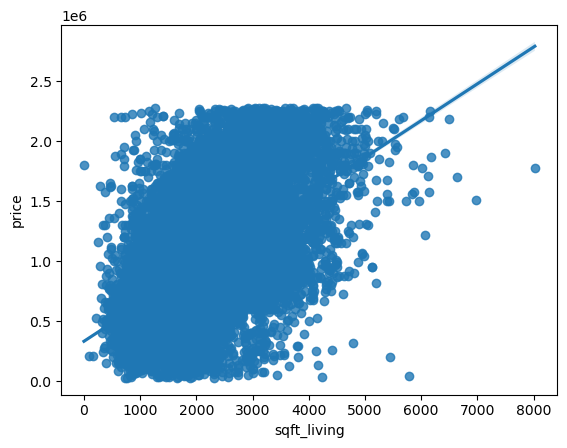

In [177]:
IQR = numeric_df['price'].quantile(.75) - numeric_df['price'].quantile(.25)
IQR_scaler = 1.5
price_outlier_bound = numeric_df['price'].quantile(.75) + IQR_scaler * IQR
no_outliers_df = numeric_df.loc[numeric_df['price'] < price_outlier_bound]

sns.regplot(x='sqft_living', y='price', data=no_outliers_df, scatter=True);

### NO OUTLIER Baseline Model Standardized Feature, Log Transformed Target
using scaled `sqft_living` - Square footage of living space in the home  
using log transformed `price` target

> STATS  
>
> R2 = .320

In [178]:
# no price outliers test split (.75 train, .25 test)
X_train_trunc, X_test_trunc, y_train_trunc, y_test_trunc = train_test_split(no_outliers_df.drop(columns='price'), 
                                                                            no_outliers_df[['price']], 
                                                                            test_size=.25, 
                                                                            random_state=42)

In [179]:
# Scale train and test feature
scaler = StandardScaler()
X_train_trunc_scaled = scaler.fit_transform(X_train_trunc[['sqft_living']])
X_test_trunc_scaled = scaler.transform(X_test[['sqft_living']])

# y = training house prices, X = scaled training sqft_living
y = y_train_trunc
X = X_train_trunc_scaled

# fit model and display statistics
baseline_trunc_scaled_model = sm.OLS(y,sm.add_constant(X))
baseline_trunc_scaled_results = baseline_trunc_scaled_model.fit()
baseline_trunc_scaled_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     9946.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:47:56   Log-Likelihood:            -3.0012e+05
No. Observations:               21120   AIC:                         6.002e+05
Df Residuals:                   21118   BIC:                         6.003e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.436e+05   2470.435    381.956      0.000    9.39e+05    9.48e+05
x1          2.464e+05   2470.435     99.730      0.000    2.42e+05    2.51e+05
==============================================================================
Omnibus:                     1111.265   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1408.160
Skew:                           0.528   Prob(JB):                    1.67e-306
Kurtosis:                       3.696   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# R2 vs Mean Error

In [180]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
ss = StandardScaler()


print("sqft_living v price")
lr.fit(X_train[['sqft_living']], y_train)
print("Train R2: ",lr.score(X_train[['sqft_living']], y_train))
print("Test R2: ",lr.score(X_test[['sqft_living']], y_test))
print("MAE: ", metrics.mean_absolute_error(y_test, lr.predict(X_test[['sqft_living']])))
print()

print("scaled(sqft_living) v price")
lr.fit(ss.fit_transform(X_train[['sqft_living']]).reshape(-1,1), y_train)
print("Train R2: ",lr.score(ss.transform(X_train[['sqft_living']]), y_train))
print("Test R2: ",lr.score(ss.transform(X_test[['sqft_living']]).reshape(-1,1), y_test))
print("MAE: ", metrics.mean_absolute_error(y_test, lr.predict(ss.transform(X_test[['sqft_living']]).reshape(-1,1))))
print()

print("sqft_living v log(price)")
lr.fit(X_train[['sqft_living']], np.log(y_train))
print("Train R2: ",lr.score(X_train[['sqft_living']], np.log(y_train)))
print("Test R2: ",lr.score(X_test[['sqft_living']], np.log(y_test)))
print("MAE: ", metrics.mean_absolute_error(y_test, np.exp(lr.predict(X_test[['sqft_living']]))))
print()

print("scaled(sqft_living) v log(price)")
lr.fit(ss.fit_transform(X_train[['sqft_living']]).reshape(-1,1), np.log(y_train))
print("Train R2: ",lr.score(ss.transform(X_train[['sqft_living']]), np.log(y_train)))
print("Test R2: ",lr.score(ss.transform(X_test[['sqft_living']]).reshape(-1,1), np.log(y_test)))
print("MAE: ", metrics.mean_absolute_error(y_test, np.exp(lr.predict(ss.transform(X_test[['sqft_living']]).reshape(-1,1)))))
print()

sqft_living v price
Train R2:  0.3570385585479118
Test R2:  0.42068780143393103
MAE:  387075.9715188815

scaled(sqft_living) v price
Train R2:  0.3570385585479118
Test R2:  0.42068780143393103
MAE:  387075.9715188815

sqft_living v log(price)
Train R2:  0.3815402107703717
Test R2:  0.40235958406794536
MAE:  387242.51256115106

scaled(sqft_living) v log(price)
Train R2:  0.3815402107703718
Test R2:  0.40235958406794536
MAE:  387242.5125611511



# ALL Numeric Features

## Standardized Features

In [231]:
# Scale train and test feature 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# y = training house prices, X = scaled training sqft_living
y = y_train
X = X_train_scaled

# fit model and display statistics
model = sm.OLS(y,sm.add_constant(X))
results = model.fit()
print_test_scores(X_train_scaled, y_train, X_test_scaled, y_test)
results.summary(xname=['const']+X_train.columns.to_list())


         Test R2: 0.38989248936469045
Test Adjusted R2: 0.38989248936469045


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     1506.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:09:50   Log-Likelihood:            -3.3559e+05
No. Observations:               22613   AIC:                         6.712e+05
Df Residuals:                   22601   BIC:                         6.713e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.107e+06   4486.183    246.702      0.000     1.1e+06    1.12e+06
bedrooms      -1.665e+05   6096.130    -27.310      0.000   -1.78e+05   -1.55e+05
bathrooms      1.208e+05   8124.781     14.872      0.000    1.05e+05    1.37e+05
sqft_living    2.999e+05   2.02e+04     14.860      0.000     2.6e+05    3.39e+05
sqft_lot      -1.305e+04   4618.710     -2.825      0.005   -2.21e+04   -3995.254
floors         -690.2016   6282.320     -0.110      0.913    -1.3e+04    1.16e+04
sqft_above     2.827e+05   1.86e+04     15.207      0.000    2.46e+05    3.19e+05
yr_built       -1.06e+05   6717.665    -15.772      0.000   -1.19e+05   -9.28e+04
sqft_basement  1.048e+05   8914.054     11.753      0.000    8.73e+04    1.22e+05
sqft_garage   -3.726e+04   6174.258     -6.034      0.000   -4.94e+04   -2.52e+04
sqft_patio     6.558e+04   5006.934     13.098      0.000    5.58e+04    7.54e+04
yr_renovated   2.193e+04   4719.911      4.646      0.000    1.27e+04    3.12e+04
==============================================================================
Omnibus:                    28103.796   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11603497.527
Skew:                           6.396   Prob(JB):                         0.00
Kurtosis:                     113.234   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Residual Graph

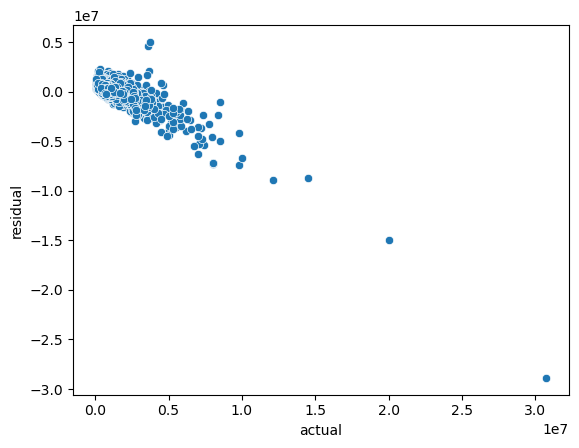

In [221]:
y_hat = results.predict(sm.add_constant(X_test_scaled)).reshape(-1,1)
sns.scatterplot(x= y_test['price'],y= (y_hat - y_test)['price'].to_list()).set(xlabel='actual', ylabel='residual');

### RFE

In [ ]:
rfe = RFE(lm, n_features_to_select=)
rfe.fit()

## Log transformed Target

In [285]:
# Scale train and test feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log transform train and test target
log_y_train = np.log(y_train)

# y = training house prices, X = scaled training sqft_living
y = log_y_train
X = X_train_scaled

# fit model and display statistics
model = sm.OLS(y,sm.add_constant(X))
results = model.fit()
print_test_scores(X, y, X_test_scaled,log_y_test)
results.summary(xname=['const']+X_train.columns.to_list())

         Test R2: 0.41886919726729
Test Adjusted R2: 0.41886919726729


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     1479.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:08:09   Log-Likelihood:                -13730.
No. Observations:               22613   AIC:                         2.748e+04
Df Residuals:                   22601   BIC:                         2.758e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.7333      0.003   4649.274      0.000      13.728      13.739
bedrooms         -0.0609      0.004    -15.178      0.000      -0.069      -0.053
bathrooms         0.0878      0.005     16.418      0.000       0.077       0.098
sqft_living       0.2023      0.013     15.227      0.000       0.176       0.228
sqft_lot         -0.0020      0.003     -0.653      0.513      -0.008       0.004
floors            0.0503      0.004     12.170      0.000       0.042       0.058
sqft_above        0.1186      0.012      9.689      0.000       0.095       0.143
yr_built         -0.0823      0.004    -18.613      0.000      -0.091      -0.074
sqft_basement     0.0629      0.006     10.710      0.000       0.051       0.074
sqft_garage      -0.0015      0.004     -0.368      0.713      -0.009       0.006
sqft_patio        0.0362      0.003     10.967      0.000       0.030       0.043
yr_renovated      0.0099      0.003      3.196      0.001       0.004       0.016
==============================================================================
Omnibus:                     5101.212   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46698.803
Skew:                          -0.826   Prob(JB):                         0.00
Kurtosis:                       9.844   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Residual Graph

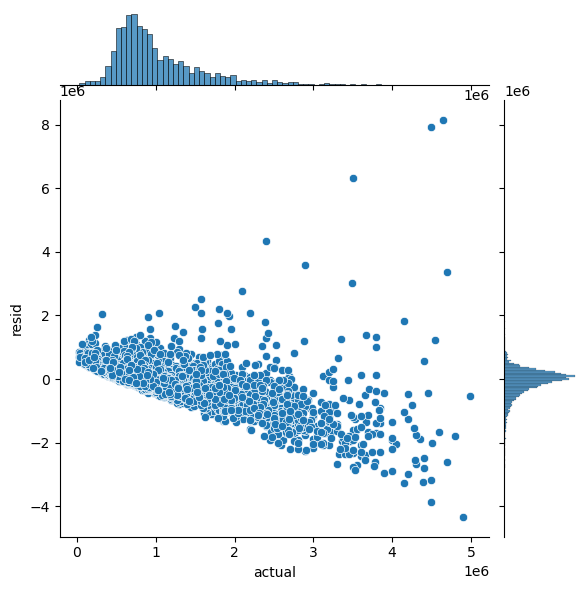

In [288]:
y_hat = np.exp(results.predict(sm.add_constant(X_test_scaled)).reshape(-1,1))

y_df = pd.DataFrame({'hat':list(y_hat[0])}, index=range(y_hat.shape[0]))
y_df['actual'] = y_test['price'].to_list()
y_df['resid'] = (y_hat - y_test)['price'].to_list()

y_df = y_df.loc[y_df['resid'] < 13000000]
y_df = y_df.loc[y_df['actual'] < 5000000]

# sns.scatterplot(x= 'actual',y= 'resid', data=y_df).set(xlabel='actual', ylabel='residual')
sns.jointplot(x= 'actual',y= 'resid', data=y_df);

### VIF

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                         
7399300360  675000.0         4        1.0         1180      7140     1.0   
8910500230  920000.0         5        2.5         2770      6703     1.0   
1180000275  311000.0         6        2.0         2880      6156     1.0   
1604601802  775000.0         3        3.0         2160      1400     2.0   
8562780790  592500.0         2        2.0         1120       758     2.0   

            yr_built  yr_renovated  sqft_home  
id                                             
7399300360      1969             0       1220  
8910500230      1950             0       3380  
1180000275      1956             0       3160  
1604601802      2010             0       2630  
8562780790      2012             0       2250

In [281]:
# columns powerset, not including empty set
col_power_set = powerset(X_train.columns)
data = [X_train[subset] for subset in col_power_set]

labels = col_power_set
vif_df = pd.DataFrame(columns=)

for i, df_ in enumerate(data):
    print(labels[i])
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [VIF(df_.values, i) for i in range(df_.shape[1])]
    
    print(vif_data.sort_values(by='VIF', ascending=False), end='\n\n')

['bedrooms', 'sqft_living']
       feature       VIF
1  sqft_living  9.689216
0     bedrooms  9.689216

['bedrooms', 'sqft_lot']
    feature       VIF
1  sqft_lot  1.075462
0  bedrooms  1.075462

['bedrooms', 'floors']
    feature       VIF
0  bedrooms  6.280857
1    floors  6.280857

['bedrooms', 'sqft_above']
      feature      VIF
0    bedrooms  7.48246
1  sqft_above  7.48246

['bedrooms', 'yr_built']
    feature        VIF
0  bedrooms  13.373455
1  yr_built  13.373455

['bedrooms', 'sqft_basement']
         feature       VIF
0       bedrooms  1.772366
1  sqft_basement  1.772366

['bedrooms', 'sqft_garage']
       feature       VIF
0     bedrooms  2.614546
1  sqft_garage  2.614546

['bedrooms', 'sqft_patio']
      feature      VIF
1  sqft_patio  1.84058
0    bedrooms  1.84058

['bedrooms', 'yr_renovated']
        feature       VIF
1  yr_renovated  1.045419
0      bedrooms  1.045419

['bathrooms', 'sqft_living']
       feature        VIF
0    bathrooms  14.101002
1  sqft_living  14.1

### all Combinations of numeric Features

In [337]:
# columns powerset, not including empty set
all_cols = X_train.columns.to_list()
num_cols = X_train.shape[1]
col_power_set = powerset(X_train.columns)
n = len(col_power_set)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(data=scaler.transform(X_train), columns=all_cols)
# X_test = pd.DataFrame(data=scaler.transform(X_test), columns=all_cols)
X_train, X_test = scale_custom(X_train,X_test,['yr_renovated'])

data_train = [X_train[subset] for subset in col_power_set]
data_test = [X_test[subset] for subset in col_power_set]
labels = col_power_set
ytrain, ytest = np.log(y_train.values), np.log(y_test.values)

feat_combs_df = pd.DataFrame(columns=['cols','train_R2','train_R2_adj','test_R2','test_R2_adj']+all_cols)

for i, data in enumerate(zip(data_train,data_test)):
    print(i, '/', n, end='\r')
    xtrain, xtest = data[0], data[1]
    train_R2 = get_train_score(xtrain,ytrain)
    train_R2_adj = get_adjusted_train_score(xtrain,ytrain)
    test_R2 = get_test_score(xtrain,ytrain,xtest,ytest)
    test_R2_adj = get_adjusted_test_score(xtrain,ytrain,xtest,ytest)

    feature_vifs = [np.nan for _ in range(num_cols)]
    used_col_iter = 0
    cols_used = xtrain.columns.to_list()
    num_cols_used = len(cols_used)
    for j in range(num_cols):
        if cols_used[used_col_iter] == all_cols[j]:
            feature_vifs[j] = VIF(xtrain.values, used_col_iter)
            used_col_iter += 1
            if used_col_iter >= num_cols_used:
                break

    feat_combs_df.loc[i] = [labels[i], train_R2, train_R2_adj, test_R2, test_R2_adj] + feature_vifs



In [312]:
feat_combs_df.sort_values(by='test_R2_adj', ascending=False)

cols  train_R2  \
1991  [bedrooms, bathrooms, sqft_living, floors, sqf...  0.418458   
1839  [bedrooms, bathrooms, sqft_living, floors, sqf...  0.418195   
2030  [bedrooms, bathrooms, sqft_living, floors, sqf...  0.418462   
1989  [bedrooms, bathrooms, sqft_living, floors, sqf...  0.418199   
2025  [bedrooms, bathrooms, sqft_living, sqft_lot, f...  0.418470   
...                                                 ...       ...   
34                                   [floors, yr_built]  0.054765   
177                  [sqft_lot, yr_built, yr_renovated]  0.032388   
47                             [yr_built, yr_renovated]  0.025972   
28                                 [sqft_lot, yr_built]  0.021154   
32                             [sqft_lot, yr_renovated]  0.012228   

      train_R2_adj   test_R2  test_R2_adj  
1991      0.418201  0.419024     0.418252  
1839      0.417963  0.418938     0.418243  
2030      0.418179  0.419068     0.418219  
1989      0.417942  0.418988     0.418217  
2025      0.418187  0.418824     0.417975  
...            ...       ...          ...  
34        0.054640  0.053970     0.053593  
177       0.032217  0.034719     0.034207  
47        0.025842  0.026691     0.026303  
28        0.021025  0.022427     0.022038  
32        0.012097  0.014122     0.013729  

[2035 rows x 5 columns]

# Categorical correlations to Price

In [47]:
cat_df = df.select_dtypes(object)
cat_df['renovated'] = numeric_df['yr_renovated'].map(lambda x: 0 if x == 0 else 1)
cat_df['has_basement'] = numeric_df['sqft_basement'].map(lambda x: 0 if x == 0 else 1)
cat_df['has_garage'] = numeric_df['sqft_garage'].map(lambda x: 0 if x == 0 else 1)
cat_df['has_patio'] = numeric_df['sqft_patio'].map(lambda x: 0 if x == 0 else 1)
display(cat_df.info())
cat_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30152 entries, 7399300360 to 9557800100
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          30152 non-null  object 
 1   waterfront    30152 non-null  object 
 2   greenbelt     30152 non-null  object 
 3   nuisance      30152 non-null  object 
 4   view          30152 non-null  object 
 5   condition     30152 non-null  object 
 6   grade         30152 non-null  object 
 7   heat_source   30120 non-null  object 
 8   sewer_system  30138 non-null  object 
 9   address       30152 non-null  object 
 10  renovated     30151 non-null  float64
 11  has_basement  30151 non-null  float64
 12  has_garage    30151 non-null  float64
 13  has_patio     30151 non-null  float64
dtypes: float64(4), object(10)
memory usage: 4.5+ MB


None

date waterfront greenbelt nuisance     view condition  \
id                                                                        
7399300360   5/24/2022         NO        NO       NO     NONE      Good   
8910500230  12/13/2021         NO        NO      YES  AVERAGE   Average   
1180000275   9/29/2021         NO        NO       NO  AVERAGE   Average   
1604601802  12/14/2021         NO        NO       NO  AVERAGE   Average   
8562780790   8/24/2021         NO        NO      YES     NONE   Average   

                grade  heat_source sewer_system  \
id                                                
7399300360  7 Average          Gas       PUBLIC   
8910500230  7 Average          Oil       PUBLIC   
1180000275  7 Average          Gas       PUBLIC   
1604601802   9 Better          Gas       PUBLIC   
8562780790  7 Average  Electricity       PUBLIC   

                                                      address  renovated  \
id                                                                         
7399300360  2102 Southeast 21st Court, Renton, Washington ...        0.0   
8910500230  11231 Greenwood Avenue North, Seattle, Washing...        0.0   
1180000275  8504 South 113th Street, Seattle, Washington 9...        0.0   
1604601802  4079 Letitia Avenue South, Seattle, Washington...        0.0   
8562780790  2193 Northwest Talus Drive, Issaquah, Washingt...        0.0   

            has_basement  has_garage  has_patio  
id                                               
7399300360           0.0         0.0        1.0  
8910500230           1.0         0.0        1.0  
1180000275           1.0         0.0        0.0  
1604601802           1.0         1.0        1.0  
8562780790           1.0         1.0        1.0

In [48]:
# cleaning categorical features
zips = []
street_name = []

# make the address data useable
for i in cat_df["address"]:
    # create variable to store partitioned strings from address column
    # first will be used in certain iterations
    info = i.split(",")
    first = info[0].split(" ")

    # store variables in appropriate lists
    zips.append(info[-2][-5:])
    street_name.append(" ".join(first[1:len(first)]))

# create columns from the lists in the cat_df
cat_df["zipcode"] = zips
cat_df["street_name"] = street_name

# remove zips codes outside King County
# https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033
ci_zips = ['98002 (Auburn)', '98092 (Auburn)', '98224 (Baring)', '98004 (Bellevue)', '98005 (Bellevue)', '98006 (Bellevue)', '98007 (Bellevue)', '98008 (Bellevue)', '98010 (Black Diamond)', '98011 (Bothell)', '98178 (Bryn Mawr-Skyway)', '98148 (Burien)', '98166 (Burien)', '98014 (Carnation)', '98077 (Cottage Lake)', '98042 (Covington)', '98198 (Des Moines)', '98019 (Duvall)', '98031 (East Hill-Meridian)', '98022 (Enumclaw)', '98058 (Fairwood)', '98024 (Fall City)', '98003 (Federal Way)', '98023 (Federal Way)', '98027 (Issaquah)', '98029 (Issaquah)', '98028 (Kenmore)', '98032 (Kent)', '98030 (Kent)', '98033 (Kirkland)', '98034 (Kirkland)', '98001 (Lakeland North)', '98038 (Maple Valley)', '98039 (Medina)', '98040 (Mercer Island)', '98045 (North Bend)', '98047 (Pacific)', '98050 (Preston)', '98051 (Ravensdale)', '98052 (Redmond)', '98055 (Renton)', '98056 (Renton)', '98057 (Renton)', '98059 (Renton)', '98074 (Sammamish)', '98075 (Sammamish)', '98188 (SeaTac)', '98199 (Seattle)', '98174 (Seattle)', '98154 (Seattle)', '98158 (Seattle)', '98164 (Seattle)', '98101 (Seattle)', '98102 (Seattle)', '98103 (Seattle)', '98104 (Seattle)', '98105 (Seattle)', '98106 (Seattle)', '98107 (Seattle)', '98108 (Seattle)', '98109 (Seattle)', '98112 (Seattle)', '98115 (Seattle)', '98116 (Seattle)', '98117 (Seattle)', '98118 (Seattle)', '98119 (Seattle)', '98121 (Seattle)', '98122 (Seattle)', '98125 (Seattle)', '98126 (Seattle)', '98133 (Seattle)', '98134 (Seattle)', '98136 (Seattle)', '98144 (Seattle)', '98155 (Shoreline)', '98177 (Shoreline)', '98288 (Skykomish)', '98065 (Snoqualmie)', '98168 (Tukwila)', '98053 (Union Hill-Novelty Hill)', '98195 (Univ Of Washington)', '98070 (Vashon)', '98146 (White Center)', '98072 (Woodinville)']
ci_zips = [x.split()[0] for x in ci_zips]
cat_df = cat_df.loc[[(i in ci_zips) for i in cat_df['zipcode'].values]]

#remove irrelevant features
cat_df.drop(columns=['date', 'address'], inplace=True)

# drop
cat_df.dropna(inplace=True)

cat_df


waterfront greenbelt nuisance     view condition      grade  \
id                                                                       
7399300360         NO        NO       NO     NONE      Good  7 Average   
8910500230         NO        NO      YES  AVERAGE   Average  7 Average   
1180000275         NO        NO       NO  AVERAGE   Average  7 Average   
1604601802         NO        NO       NO  AVERAGE   Average   9 Better   
8562780790         NO        NO      YES     NONE   Average  7 Average   
...               ...       ...      ...      ...       ...        ...   
7834800180         NO        NO       NO     NONE      Good     8 Good   
194000695          NO        NO       NO     FAIR   Average  7 Average   
7960100080         NO        NO      YES     NONE   Average  7 Average   
2781280080         NO        NO       NO     NONE   Average     8 Good   
9557800100         NO        NO       NO     NONE   Average  7 Average   

            heat_source sewer_system  renovated  has_basement  has_garage  \
id                                                                          
7399300360          Gas       PUBLIC        0.0           0.0         0.0   
8910500230          Oil       PUBLIC        0.0           1.0         0.0   
1180000275          Gas       PUBLIC        0.0           1.0         0.0   
1604601802          Gas       PUBLIC        0.0           1.0         1.0   
8562780790  Electricity       PUBLIC        0.0           1.0         1.0   
...                 ...          ...        ...           ...         ...   
7834800180          Oil       PUBLIC        0.0           1.0         0.0   
194000695           Gas       PUBLIC        0.0           0.0         0.0   
7960100080          Gas       PUBLIC        0.0           1.0         1.0   
2781280080          Gas       PUBLIC        0.0           1.0         1.0   
9557800100          Oil       PUBLIC        0.0           0.0         1.0   

            has_patio zipcode                street_name  
id                                                        
7399300360        1.0   98055       Southeast 21st Court  
8910500230        1.0   98133     Greenwood Avenue North  
1180000275        0.0   98178         South 113th Street  
1604601802        1.0   98118       Letitia Avenue South  
8562780790        1.0   98027      Northwest Talus Drive  
...               ...     ...                        ...  
7834800180        1.0   98103       Eastern Avenue North  
194000695         1.0   98116      44th Avenue Southwest  
7960100080        1.0   98122  Martin Luther King Jr Way  
2781280080        1.0   98055     114th Avenue Southeast  
9557800100        0.0   98148           7th Avenue South  

[29147 rows x 14 columns]

In [37]:
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_data = encoder.fit_transform(cat_df)
one_hot_df = pd.DataFrame(data=encoded_data, columns=encoder.get_feature_names())
one_hot_df

x0_YES  x1_YES  x2_YES  x3_EXCELLENT  x3_FAIR  x3_GOOD  x3_NONE  \
0         0.0     0.0     0.0           0.0      0.0      0.0      1.0   
1         0.0     0.0     1.0           0.0      0.0      0.0      0.0   
2         0.0     0.0     0.0           0.0      0.0      0.0      0.0   
3         0.0     0.0     0.0           0.0      0.0      0.0      0.0   
4         0.0     0.0     1.0           0.0      0.0      0.0      1.0   
...       ...     ...     ...           ...      ...      ...      ...   
29142     0.0     0.0     0.0           0.0      0.0      0.0      1.0   
29143     0.0     0.0     0.0           0.0      1.0      0.0      0.0   
29144     0.0     0.0     1.0           0.0      0.0      0.0      1.0   
29145     0.0     0.0     0.0           0.0      0.0      0.0      1.0   
29146     0.0     0.0     0.0           0.0      0.0      0.0      1.0   

       x4_Fair  x4_Good  x4_Poor  ...  x13_Wright Avenue Southwest  \
0          0.0      1.0      0.0  ...                          0.0   
1          0.0      0.0      0.0  ...                          0.0   
2          0.0      0.0      0.0  ...                          0.0   
3          0.0      0.0      0.0  ...                          0.0   
4          0.0      0.0      0.0  ...                          0.0   
...        ...      ...      ...  ...                          ...   
29142      0.0      1.0      0.0  ...                          0.0   
29143      0.0      0.0      0.0  ...                          0.0   
29144      0.0      0.0      0.0  ...                          0.0   
29145      0.0      0.0      0.0  ...                          0.0   
29146      0.0      0.0      0.0  ...                          0.0   

       x13_Wynalda Drive  x13_Yakima Ave S  x13_Yakima Avenue South  \
0                    0.0               0.0                      0.0   
1                    0.0               0.0                      0.0   
2                    0.0               0.0                      0.0   
3                    0.0               0.0                      0.0   
4                    0.0               0.0                      0.0   
...                  ...               ...                      ...   
29142                0.0               0.0                      0.0   
29143                0.0               0.0                      0.0   
29144                0.0               0.0                      0.0   
29145                0.0               0.0                      0.0   
29146                0.0               0.0                      0.0   

       x13_Yakima Place Southeast  x13_Yale Ave E  x13_Yale Avenue East  \
0                             0.0             0.0                   0.0   
1                             0.0             0.0                   0.0   
2                             0.0             0.0                   0.0   
3                             0.0             0.0                   0.0   
4                             0.0             0.0                   0.0   
...                           ...             ...                   ...   
29142                         0.0             0.0                   0.0   
29143                         0.0             0.0                   0.0   
29144                         0.0             0.0                   0.0   
29145                         0.0             0.0                   0.0   
29146                         0.0             0.0                   0.0   

       x13_Zemp Way  x13_Zillah Place Southeast  x13_Zurs Strasse  
0               0.0                         0.0               0.0  
1               0.0                         0.0               0.0  
2               0.0                         0.0               0.0  
3               0.0                         0.0               0.0  
4               0.0                         0.0               0.0  
...             ...                         ...               ...  
29142           0.0                         0.0

# Combined data

In [8]:
cat_cols = ['has_basement', 'has_garage', 'has_patio', 'renovated']
combined_df = numeric_df.merge(cat_df[cat_cols], 
                               how='inner',
                               left_on=numeric_df.index, 
                               right_on=cat_df.index).set_index('key_0')
combined_df

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
key_0                                                                       
7399300360   675000.0         4        1.0         1180      7140     1.0   
8910500230   920000.0         5        2.5         2770      6703     1.0   
1180000275   311000.0         6        2.0         2880      6156     1.0   
1604601802   775000.0         3        3.0         2160      1400     2.0   
8562780790   592500.0         2        2.0         1120       758     2.0   
...               ...       ...        ...          ...       ...     ...   
7834800180  1555000.0         5        2.0         1910      4000     1.5   
194000695   1313000.0         3        2.0         2020      5800     2.0   
7960100080   800000.0         3        2.0         1620      3600     1.0   
2781280080   775000.0         3        2.5         2570      2889     2.0   
9557800100   500000.0         3        1.5         1200     11058     1.0   

            sqft_above  yr_built  sqft_home  sqft_basement  sqft_garage  \
key_0                                                                     
7399300360        1180      1969       1220              0            0   
8910500230        1570      1950       3380           1570            0   
1180000275        1580      1956       3160           1580            0   
1604601802        1090      2010       2630           1070          200   
8562780790        1120      2012       2250            550          550   
...                ...       ...        ...            ...          ...   
7834800180        1600      1921       2940           1130            0   
194000695         2020      2011       2540              0            0   
7960100080         940      1995       2210            920          240   
2781280080        1830      2006       3150            740          480   
9557800100        1200      1965       1620              0          420   

            sqft_patio  yr_renovated  has_basement  has_garage  has_patio  \
key_0                                                                       
7399300360          40             0           0.0         0.0        1.0   
8910500230         240             0           1.0         0.0        1.0   
1180000275           0             0           1.0         0.0        0.0   
1604601802         270             0           1.0         1.0        1.0   
8562780790          30             0           1.0         1.0        1.0   
...                ...           ...           ...         ...        ...   
7834800180         210             0           1.0         0.0        1.0   
194000695          520             0           0.0         0.0        1.0   
7960100080         110             0           1.0         1.0        1.0   
2781280080         100             0           1.0         1.0        1.0   
9557800100           0             0           0.0         1.0        0.0   

            renovated  
key_0                  
7399300360        0.0  
8910500230        0.0  
1180000275        0.0  
1604601802        0.0  
8562780790        0.0  
...               ...  
7834800180        0.0  
194000695         0.0  
7960100080        0.0  
2781280080        0.0  
9557800100        0.0  

[30151 rows x 17 columns]

### Train - Test Split

In [9]:
# numeric Train test split (.75 train, .25 test)
X_train, X_test, y_train, y_test = train_test_split(combined_df.drop(columns='price'), combined_df[['price']], test_size=.25, random_state=42)


### custom scaling

In [10]:
numeric_xtrain, numeric_xtest = scale_custom(X_train.drop(columns=cat_cols), X_test.drop(columns=cat_cols), bad_cols)
X_train = numeric_xtrain.join(X_train[cat_cols],
                              how='inner')
X_test = numeric_xtest.join(X_test[cat_cols],
                            how='inner')

# model test

df = df.loc[df['bedrooms'] <= 10]  
df = df.loc[df['sqft_living'] <= 8000]  
price up to 3e6, np.log(price)  
df.grade #1-13 instead of 0-12  
yr_renovated to binary   
yr_built to age   
log (age, living, above)  

use features log_living, lov_age, bed, bath, floor, view, condition, grade, zipohe

average price by zipcode, zipcode stats
sqft predictor
feature importance


In [107]:
df = pd.read_csv('data/kc_house_data.csv', index_col=0) # (30155,25), 3 duplicated entries
# display(df.head())
# print("Deleted Duplicate Entries:")
# display(df.loc[df.duplicated(keep=False)])
df.drop_duplicates(inplace=True)

In [108]:
# numeric Train test split (.75 train, .25 test)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'), df[['price']], test_size=.25, random_state=42)


In [109]:
# remove price outliers and log price
y_train = y_train.loc[(y_train['price'] > 78000) & (y_train['price'] < 7000000)]
X_train = X_train.loc[y_train.index]
y_test = y_test.loc[(y_test['price'] > 78000) & (y_test['price'] < 7000000)]
X_test = X_test.loc[y_test.index]

y_train['price'] = np.log(y_train['price'])
y_test['price'] = np.log(y_test['price'])

In [110]:
# remove outliers from bedroom, sqft_living
X_train = X_train.loc[X_train['bedrooms'] <= 10]  
X_train = X_train.loc[(X_train['sqft_living'] <= 8000) & (X_train['sqft_living'] > 400)]  
y_train = y_train.loc[X_train.index]

X_test = X_test.loc[X_test['bedrooms'] <= 10]  
X_test = X_test.loc[X_test['sqft_living'] <= 8000]  
X_test = X_test.loc[(X_test['sqft_living'] <= 8000) & (X_test['sqft_living'] > 400)]  
y_test = y_test.loc[X_test.index]


In [111]:
# Ordinal Encoding
oe_cols = ['view', 'condition', 'grade']
oe_orders = [['NONE','FAIR','AVERAGE','GOOD','EXCELLENT'],
             ['Poor','Fair','Average','Good','Very Good'],
             ['1 Cabin',
              '2 Substandard',
              '3 Poor',
              '4 Low',
              '5 Fair',
              '6 Low Average',
              '7 Average',
              '8 Good',
              '9 Better',
              '10 Very Good',
              '11 Excellent',
              '12 Luxury',
              '13 Mansion']]

for col, order in zip(oe_cols,oe_orders):
    oe = OrdinalEncoder([order]).fit(X_train[[col]])
    X_train[col] = oe.transform(X_train[[col]])
    X_test[col] = oe.transform(X_test[[col]])

# keep grade as 1-13 instead of 0-12
X_train['grade'] = X_train['grade']+1
X_test['grade'] = X_test['grade']+1



In [112]:
# label Encoding
le_cols = ['waterfront','greenbelt', 'nuisance']

for col in le_cols:
    le = LabelEncoder().fit(X_train[[col]])
    X_train[col] = le.transform(X_train[[col]])
    X_test[col] = le.transform(X_test[[col]])

In [113]:
# create new column renovated if home has been renovated, 
X_train['renovated'] = (X_train['yr_renovated'] > 0).astype(int)
X_test['renovated'] = (X_test['yr_renovated'] > 0).astype(int)



In [114]:
# yr_built to age
X_train['age'] = 2023 - X_train['yr_built']
X_test['age'] = 2023 - X_test['yr_built']

In [115]:
# setting up zipcode column

# King County Zipcodes
# https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033
ci_zips = ['98002 (Auburn)', '98092 (Auburn)', '98224 (Baring)', '98004 (Bellevue)', '98005 (Bellevue)', '98006 (Bellevue)', '98007 (Bellevue)', '98008 (Bellevue)', '98010 (Black Diamond)', '98011 (Bothell)', '98178 (Bryn Mawr-Skyway)', '98148 (Burien)', '98166 (Burien)', '98014 (Carnation)', '98077 (Cottage Lake)', '98042 (Covington)', '98198 (Des Moines)', '98019 (Duvall)', '98031 (East Hill-Meridian)', '98022 (Enumclaw)', '98058 (Fairwood)', '98024 (Fall City)', '98003 (Federal Way)', '98023 (Federal Way)', '98027 (Issaquah)', '98029 (Issaquah)', '98028 (Kenmore)', '98032 (Kent)', '98030 (Kent)', '98033 (Kirkland)', '98034 (Kirkland)', '98001 (Lakeland North)', '98038 (Maple Valley)', '98039 (Medina)', '98040 (Mercer Island)', '98045 (North Bend)', '98047 (Pacific)', '98050 (Preston)', '98051 (Ravensdale)', '98052 (Redmond)', '98055 (Renton)', '98056 (Renton)', '98057 (Renton)', '98059 (Renton)', '98074 (Sammamish)', '98075 (Sammamish)', '98188 (SeaTac)', '98199 (Seattle)', '98174 (Seattle)', '98154 (Seattle)', '98158 (Seattle)', '98164 (Seattle)', '98101 (Seattle)', '98102 (Seattle)', '98103 (Seattle)', '98104 (Seattle)', '98105 (Seattle)', '98106 (Seattle)', '98107 (Seattle)', '98108 (Seattle)', '98109 (Seattle)', '98112 (Seattle)', '98115 (Seattle)', '98116 (Seattle)', '98117 (Seattle)', '98118 (Seattle)', '98119 (Seattle)', '98121 (Seattle)', '98122 (Seattle)', '98125 (Seattle)', '98126 (Seattle)', '98133 (Seattle)', '98134 (Seattle)', '98136 (Seattle)', '98144 (Seattle)', '98155 (Shoreline)', '98177 (Shoreline)', '98288 (Skykomish)', '98065 (Snoqualmie)', '98168 (Tukwila)', '98053 (Union Hill-Novelty Hill)', '98195 (Univ Of Washington)', '98070 (Vashon)', '98146 (White Center)', '98072 (Woodinville)']
ci_zips = set([x.split()[0] for x in ci_zips])

X_train['zipcode'] = [address.split(',')[-2][-5:] for address in X_train['address']]
X_train['zipcode'] = X_train['zipcode'].apply(lambda x: x if x in ci_zips else np.nan)

X_test['zipcode'] = [address.split(',')[-2][-5:] for address in X_test['address']]
X_test['zipcode'] = X_test['zipcode'].apply(lambda x: x if x in ci_zips else np.nan)

# drop rows outside King county
old_idxs = set(X_train.index)
X_train.dropna(inplace=True)
y_train.drop(index= old_idxs - set(X_train.index), inplace=True)

old_idxs = set(X_test.index)
X_test.dropna(inplace=True)
y_test.drop(index= old_idxs - set(X_test.index), inplace=True)

# setting up streetname column
X_train['street_name'] = [address.split(',')[0] for address in X_train['address']]
X_test['street_name'] = [address.split(',')[0] for address in X_test['address']]


In [116]:
ohe_cols = ['zipcode']

ohe = OneHotEncoder(sparse = False, drop='first')
train_ohe_df = ohe.fit_transform(X_train[ohe_cols])
train_ohe_df = pd.DataFrame(train_ohe_df, columns = ohe.get_feature_names(), index = X_train.index)
train_ohe_df

test_ohe_df = ohe.transform(X_test[ohe_cols])
test_ohe_df = pd.DataFrame(test_ohe_df, columns = ohe.get_feature_names(), index = X_test.index)

### Scaling

In [117]:
# log scaling sqft_living, age
X_train[['log_sqft_living','log_age']] = np.log(X_train[['sqft_living','age']])
X_test[['log_sqft_living','log_age']] = np.log(X_test[['sqft_living','age']])


### Combining Features and cropping target to match feature size

In [118]:
# regular Features
model_cols = ['log_sqft_living', 'log_age', 'bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 'renovated']

X_train = X_train[model_cols]
X_train = pd.concat([X_train, train_ohe_df], 1)

X_test = X_test[model_cols]
X_test = pd.concat([X_test, test_ohe_df], 1)

y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

### distrs

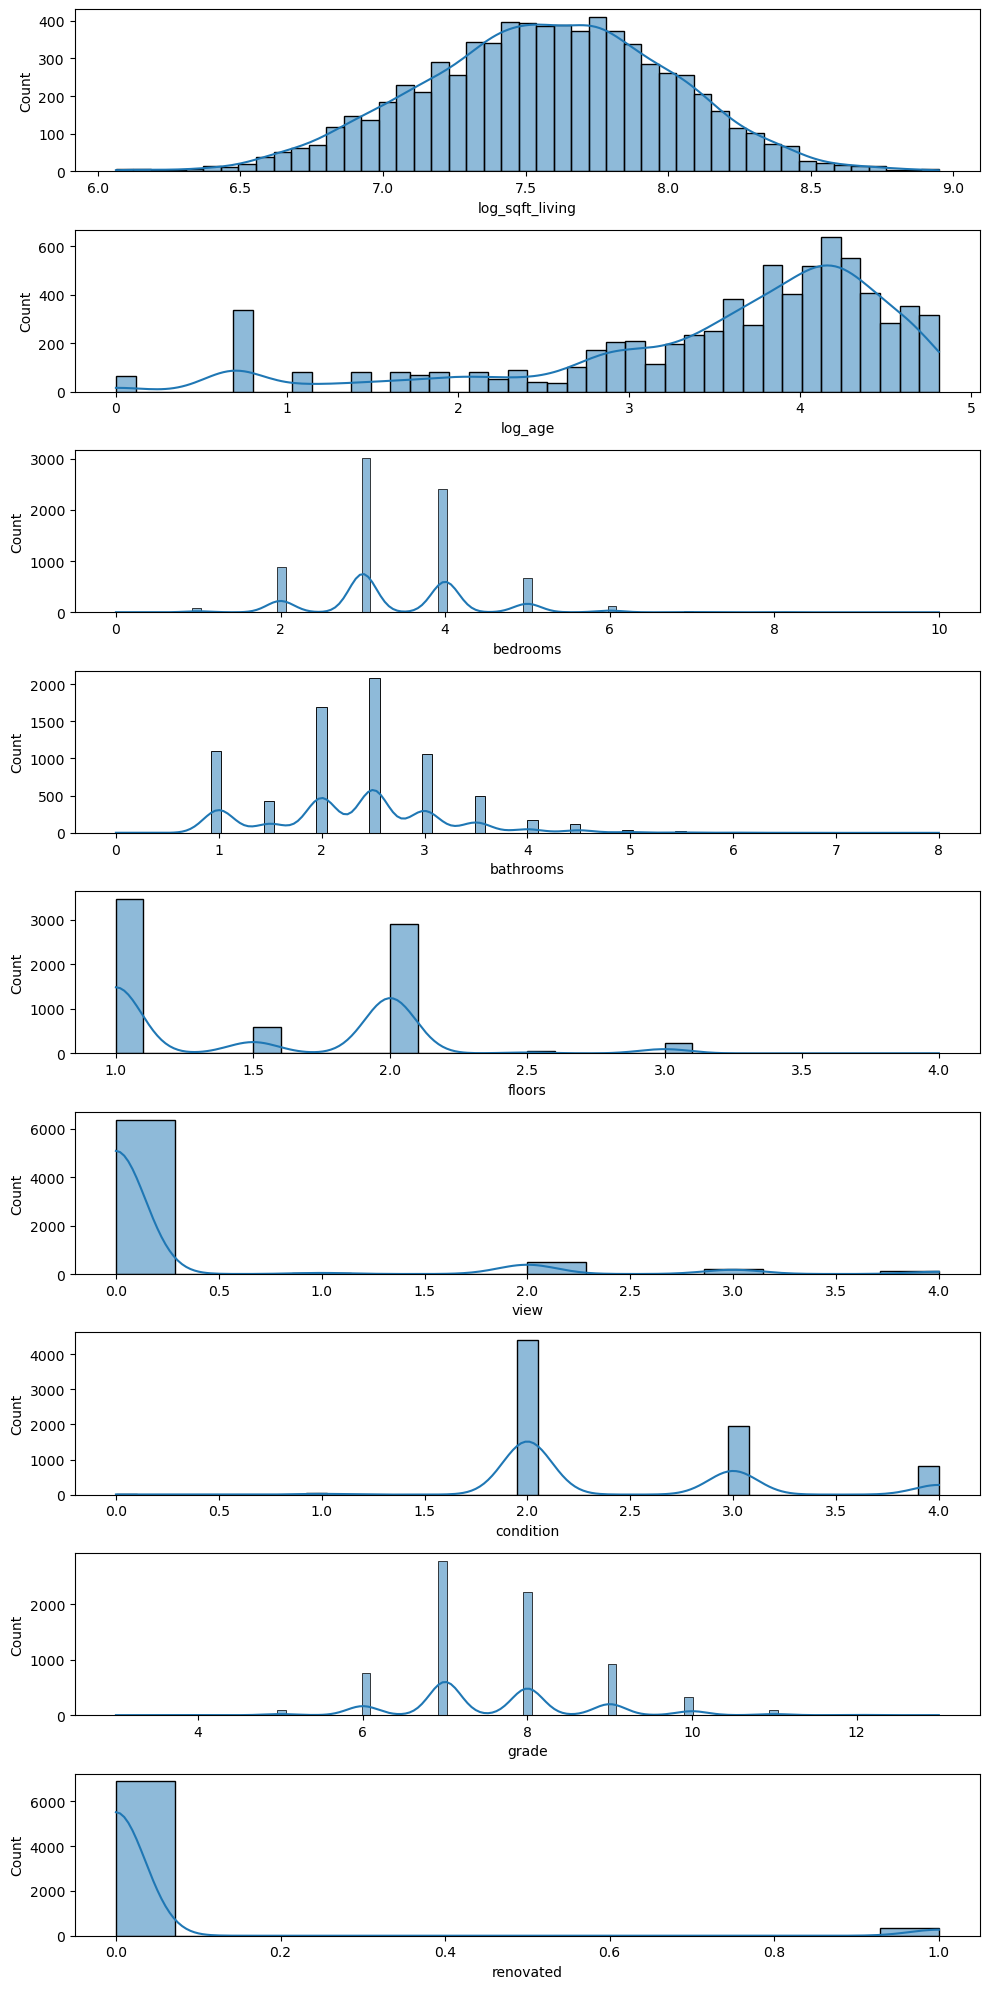

In [223]:
fig, ax = plt.subplots(nrows=len(model_cols), figsize=(10,20))
for i,col in enumerate(model_cols):
    # sns.scatterplot(x=col,y='price', data=pd.concat([X_train,y_train],1),ax=ax[i])
    sns.histplot(x=col,data=X_test, kde=True,ax=ax[i])
plt.tight_layout()

In [119]:
# sklearn
lr = lm.LinearRegression()
lr.fit(X_train,y_train)
print("Train R2:", get_train_score(X_train, y_train))
print("Train Adjusted R2:", get_adjusted_train_score(X_train, y_train))
print_test_scores(X_train, y_train, X_test, y_test)

# statsmodel
model = sm.OLS(y_train,sm.add_constant(X_train))
results = model.fit()
results.summary()

Train R2: 0.7104493955357127
Train Adjusted R2: 0.7090353472928772
         Test R2: 0.7293646643049162
Test Adjusted R2: 0.7293646643049162


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     632.3
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:45:27   Log-Likelihood:                -4666.0
No. Observations:               21733   AIC:                             9502.
Df Residuals:                   21648   BIC:                         1.018e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.2623      0.061    152.431      0.000       9.143       9.381
log_sqft_living     0.4110      0.010     41.395      0.000       0.392       0.431
log_age            -0.0016      0.003     -0.562      0.574      -0.007       0.004
bedrooms           -0.0046      0.003     -1.513      0.130      -0.011       0.001
bathrooms           0.0224      0.004      5.531      0.000       0.014       0.030
floors             -0.0141      0.005     -2.680      0.007      -0.024      -0.004
view                0.0748      0.003     28.488      0.000       0.070       0.080
condition           0.0542      0.003     16.958      0.000       0.048       0.061
grade               0.1038      0.003     33.633      0.000       0.098       0.110
renovated           0.0780      0.010      7.654      0.000       0.058       0.098
x0_98002           -0.0590      0.023     -2.563      0.010      -0.104      -0.014
x0_98003           -0.0472      0.022     -2.169      0.030      -0.090      -0.005
x0_98004            1.1768      0.025     47.875      0.000       1.129       1.225
x0_98005            0.8791      0.030     29.470      0.000       0.821       0.938
x0_98006            0.7321      0.021     34.505      0.000       0.690       0.774
x0_98007            0.7275      0.032     22.633      0.000       0.664       0.790
x0_98008            0.7482      0.023     32.975      0.000       0.704       0.793
x0_98010            0.1315      0.024      5.454      0.000       0.084       0.179
x0_98011            0.5456      0.026     20.920      0.000       0.494       0.597
x0_98014            0.3130      0.031      9.996      0.000       0.252       0.374
x0_98019            0.3459      0.027     12.787      0.000       0.293       0.399
x0_98022            0.0198      0.021      0.923      0.356      -0.022       0.062
x0_98023           -0.0431      0.019     -2.233      0.026      -0.081      -0.005
x0_98024            0.6009      0.035     17.294      0.000       0.533       0.669
x0_98027            0.5433      0.022     24.199      0.000       0.499       0.587
x0_98028            0.4601      0.023     19.846      0.000       0.415       0.506
x0_98029            0.6761      0.024     28.339      0.000       0.629       0.723
x0_98030            0.0233      0.022      1.041      0.298      -0.021       0.067
x0_98031            0.0476      0.021      2.295      0.022       0.007       0.088
x0_98032            0.0264      0.029      0.915      0.360      -0.030       0.083
x0_98033            0.9346      0.020     46.378      0.000       0.895       0.974
x0_98034            0.6410      0.019     33.210      0.000       0.603       0.679
x0_98038            0.2071      0.018     11.241      0.000       0.171       0.243
x0_98039            1.5337      0.052     29.772      0.000

In [225]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [VIF(X_train.values, i) for i in range(X_train.shape[1])]
vif_data.sort_values(by='VIF', ascending=False, inplace=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(vif_data)

feature         VIF
0   log_sqft_living  291.084495
7             grade  132.931173
1           log_age   27.558794
2          bedrooms   24.767646
3         bathrooms   20.483595
4            floors   17.289478
6         condition   16.353968
34         x0_98042    2.639896
31         x0_98038    2.416377
61         x0_98115    2.242791
54         x0_98103    2.214279
63         x0_98117    2.155600
21         x0_98023    2.116978
30         x0_98034    2.112054
69         x0_98133    2.073146
44         x0_98058    2.053030
29         x0_98033    1.983202
52         x0_98092    1.954118
64         x0_98118    1.934919
39         x0_98052    1.932588
45         x0_98059    1.889005
13         x0_98006    1.864882
27         x0_98031    1.832284
74         x0_98155    1.809571
42         x0_98056    1.808420
56         x0_98106    1.794504
67         x0_98125    1.765612
20         x0_98022    1.759635
35         x0_98045    1.752475
66         x0_98122    1.724196
57         x0_98107    1.719526
50         x0_98075    1.717434
10         x0_98003    1.693316
81         x0_98199    1.683938
49         x0_98074    1.682352
71         x0_98144    1.681091
40         x0_98053    1.680265
23         x0_98027    1.663044
80         x0_98198    1.660514
68         x0_98126    1.655957
26         x0_98030    1.629204
15         x0_98008    1.627134
62         x0_98116    1.618273
72         x0_98146    1.615552
33         x0_98040    1.605725
76         x0_98168    1.585688
24         x0_98028    1.576201
9          x0_98002    1.574907
16         x0_98010    1.568035
48         x0_98072    1.566336
25         x0_98029    1.558075
78         x0_98178    1.555969
75         x0_98166    1.552905
11         x0_98004    1.536639
60         x0_98112    1.519241
55         x0_98105    1.511444
46         x0_98065    1.504881
58         x0_98108    1.483008
77         x0_98177    1.460337
51         x0_98077    1.451280
70         x0_98136    1.450720
17         x0_98011    1.406914
65         x0_98119    1.387278
19         x0_98019    1.371708
47         x0_98070    1.347413
41         x0_98055    1.339233
12         x0_98005    1.311950
28         x0_98032    1.299228
5              view    1.297142
79         x0_98188    1.294023
53         x0_98102    1.261105
18         x0_98014    1.249117
14         x0_98007    1.235002
59         x0_98109    1.209593
43         x0_98057    1.199234
22         x0_98024    1.197238
8         renovated    1.158441
73         x0_98148    1.157540
36         x0_98047    1.116789
38         x0_98051    1.096452
32         x0_98039    1.085056
83         x0_98288    1.022210
82         x0_98224    1.007038
37         x0_98050    1.003176

In [226]:
feat_names = X_train.columns.to_list()[:122]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    coefs = pd.DataFrame(columns=['feature','abs_coef_'])
    coefs['abs_coef_'] = pd.Series(np.abs(lr.coef_.flatten())).sort_values(ascending=False)
    coefs['feature'] = [(feat_names[i] if i < 122 else np.nan) for i in list(coefs['abs_coef_'].index)]
    display(coefs)

feature  abs_coef_
32         x0_98039   1.533694
11         x0_98004   1.176795
29         x0_98033   0.934592
33         x0_98040   0.908263
12         x0_98005   0.879073
60         x0_98112   0.792631
39         x0_98052   0.756320
50         x0_98075   0.750637
15         x0_98008   0.748194
13         x0_98006   0.732065
14         x0_98007   0.727471
49         x0_98074   0.714565
53         x0_98102   0.707509
65         x0_98119   0.684574
81         x0_98199   0.682603
40         x0_98053   0.679363
59         x0_98109   0.678740
25         x0_98029   0.676081
55         x0_98105   0.670011
30         x0_98034   0.640973
37         x0_98050   0.634437
61         x0_98115   0.619149
57         x0_98107   0.612698
51         x0_98077   0.610639
54         x0_98103   0.608305
22         x0_98024   0.600905
63         x0_98117   0.597634
48         x0_98072   0.587318
17         x0_98011   0.545609
66         x0_98122   0.544730
23         x0_98027   0.543286
62         x0_98116   0.534375
71         x0_98144   0.486076
70         x0_98136   0.482914
46         x0_98065   0.476404
77         x0_98177   0.472730
24         x0_98028   0.460069
67         x0_98125   0.450575
74         x0_98155   0.441397
82         x0_98224   0.425103
0   log_sqft_living   0.411038
69         x0_98133   0.363665
35         x0_98045   0.362189
68         x0_98126   0.355898
45         x0_98059   0.355824
64         x0_98118   0.349098
19         x0_98019   0.345889
47         x0_98070   0.322755
42         x0_98056   0.316599
18         x0_98014   0.312980
72         x0_98146   0.272363
58         x0_98108   0.253767
56         x0_98106   0.228588
75         x0_98166   0.214027
38         x0_98051   0.209891
31         x0_98038   0.207070
78         x0_98178   0.157988
44         x0_98058   0.153457
43         x0_98057   0.140274
73         x0_98148   0.134119
16         x0_98010   0.131483
79         x0_98188   0.118727
7             grade   0.103770
41         x0_98055   0.086276
76         x0_98168   0.081900
8         renovated   0.077982
5              view   0.074808
83         x0_98288   0.063189
9          x0_98002   0.059000
6         condition   0.054233
27         x0_98031   0.047553
10         x0_98003   0.047228
21         x0_98023   0.043114
34         x0_98042   0.042566
80         x0_98198   0.031448
28         x0_98032   0.026442
36         x0_98047   0.024749
26         x0_98030   0.023342
3         bathrooms   0.022427
20         x0_98022   0.019760
4            floors   0.014114
52         x0_98092   0.005490
2          bedrooms   0.004636
1           log_age   0.001645

### Residual Plot

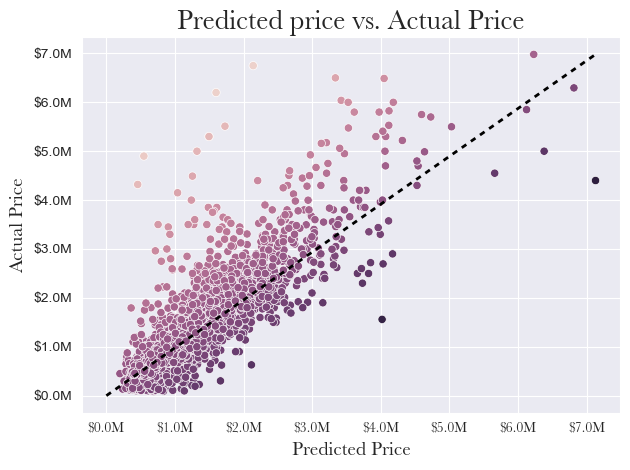

In [123]:
y_hat = np.exp(lr.predict(X_test))

y_df = pd.DataFrame({'hat':y_hat.flatten()}, index=range(y_hat.shape[0]))
y_df['actual'] = np.exp(y_test['price']).to_list()
y_df['resid'] = y_df['hat'] - y_df['actual']

fig, ax = plt.subplots()
sns.scatterplot(x='hat',y='actual', data=y_df, hue='resid')
ax.legend([],[], frameon=False)
plt.xlabel('Predicted Price', fontdict={'fontfamily':'Baskerville',
                                        'fontsize':14,
                                        'fontweight':'bold'})
plt.ylabel('Actual Price', fontdict={'fontfamily':'Baskerville',
                                     'fontsize':14,
                                     'fontweight':'bold'})
plt.title('Predicted price vs. Actual Price', fontdict={'fontfamily':'Baskerville',
                                                        'fontsize':20,
                                                        'fontweight':'bold'})
plt.xticks(fontfamily='Baskerville')
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fM' % (x * 1e-6))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
plt.plot([0, y_df['hat'].max()], [0, y_df['actual'].max()], linewidth=2, color='black', dashes=[2,2])
plt.tight_layout()


plt.show()

### correlations

In [228]:
corr_df = X_train.corr().abs()
min_corr = .3
top_corrs = pd.DataFrame(columns=['corr','index','col'])
for index in corr_df.index:
    for col in corr_df.columns:
        if corr_df.loc[index,col] > min_corr and corr_df.loc[index,col] != 1:
            top_corrs.loc[top_corrs.shape[0]+1] = [corr_df.loc[index,col], index, col]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    cor = top_corrs.sort_values(by='corr', ascending=False)
    display(cor.iloc[[i*2 for i in range(cor.shape[0]//2)]])
    display(top_corrs.groupby('index').count().sort_values(by='col', ascending=False))
    display(top_corrs.groupby('index').mean().sort_values(by='corr', ascending=False))

corr            index              col
14  0.769778        bathrooms  log_sqft_living
5   0.717349  log_sqft_living            grade
2   0.675363  log_sqft_living         bedrooms
18  0.644365        bathrooms            grade
8   0.601882          log_age           floors
16  0.592629        bathrooms         bedrooms
28  0.474759            grade           floors
25  0.436233            grade          log_age
21  0.434130           floors        bathrooms
15  0.432056        bathrooms          log_age
13  0.382261         bedrooms            grade
19  0.372510           floors  log_sqft_living
9   0.346274          log_age        condition
6   0.313532          log_age  log_sqft_living

corr  col
index                     
bathrooms           5    5
grade               5    5
log_age             5    5
log_sqft_living     5    5
floors              4    4
bedrooms            3    3
condition           1    1

corr
index                    
bathrooms        0.574592
log_sqft_living  0.569706
bedrooms         0.550084
grade            0.530993
floors           0.470820
log_age          0.425995
condition        0.346274

# Model Pipeline

In [170]:
df = pd.read_csv('data/kc_house_data.csv', index_col=0) # (30155,25), 3 duplicated entries
# display(df.head())
# print("Deleted Duplicate Entries:")
# display(df.loc[df.duplicated(keep=False)])
df.drop_duplicates(inplace=True)

In [171]:
# numeric Train test split (.75 train, .25 test)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'), df[['price']], test_size=.25, random_state=42)


In [172]:
# remove price outliers
y_train = y_train.loc[(y_train['price'] > 78000) & (y_train['price'] < 7000000)]
X_train = X_train.loc[y_train.index]
y_test = y_test.loc[(y_test['price'] > 78000) & (y_test['price'] < 7000000)]
X_test = X_test.loc[y_test.index]


In [173]:
# remove outliers from bedroom, sqft_living
X_train = X_train.loc[X_train['bedrooms'] <= 10]  
X_train = X_train.loc[(X_train['sqft_living'] <= 8000) & (X_train['sqft_living'] > 400)]  
y_train = y_train.loc[X_train.index]

X_test = X_test.loc[X_test['bedrooms'] <= 10]  
X_test = X_test.loc[X_test['sqft_living'] <= 8000]  
X_test = X_test.loc[(X_test['sqft_living'] <= 8000) & (X_test['sqft_living'] > 400)]  
y_test = y_test.loc[X_test.index]


In [174]:
# Ordinal Encoding
oe_cols = ['view', 'condition', 'grade']
oe_orders = [['NONE','FAIR','AVERAGE','GOOD','EXCELLENT'],
             ['Poor','Fair','Average','Good','Very Good'],
             ['1 Cabin',
              '2 Substandard',
              '3 Poor',
              '4 Low',
              '5 Fair',
              '6 Low Average',
              '7 Average',
              '8 Good',
              '9 Better',
              '10 Very Good',
              '11 Excellent',
              '12 Luxury',
              '13 Mansion']]

for col, order in zip(oe_cols,oe_orders):
    oe = OrdinalEncoder([order]).fit(X_train[[col]])
    X_train[col] = oe.transform(X_train[[col]])
    X_test[col] = oe.transform(X_test[[col]])



In [175]:
# label Encoding
le_cols = ['waterfront','greenbelt', 'nuisance']

for col in le_cols:
    le = LabelEncoder().fit(X_train[[col]])
    X_train[col] = le.transform(X_train[[col]])
    X_test[col] = le.transform(X_test[[col]])

In [176]:
# setting up zipcode column

# King County Zipcodes
# https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033
ci_zips = ['98002 (Auburn)', '98092 (Auburn)', '98224 (Baring)', '98004 (Bellevue)', '98005 (Bellevue)', '98006 (Bellevue)', '98007 (Bellevue)', '98008 (Bellevue)', '98010 (Black Diamond)', '98011 (Bothell)', '98178 (Bryn Mawr-Skyway)', '98148 (Burien)', '98166 (Burien)', '98014 (Carnation)', '98077 (Cottage Lake)', '98042 (Covington)', '98198 (Des Moines)', '98019 (Duvall)', '98031 (East Hill-Meridian)', '98022 (Enumclaw)', '98058 (Fairwood)', '98024 (Fall City)', '98003 (Federal Way)', '98023 (Federal Way)', '98027 (Issaquah)', '98029 (Issaquah)', '98028 (Kenmore)', '98032 (Kent)', '98030 (Kent)', '98033 (Kirkland)', '98034 (Kirkland)', '98001 (Lakeland North)', '98038 (Maple Valley)', '98039 (Medina)', '98040 (Mercer Island)', '98045 (North Bend)', '98047 (Pacific)', '98050 (Preston)', '98051 (Ravensdale)', '98052 (Redmond)', '98055 (Renton)', '98056 (Renton)', '98057 (Renton)', '98059 (Renton)', '98074 (Sammamish)', '98075 (Sammamish)', '98188 (SeaTac)', '98199 (Seattle)', '98174 (Seattle)', '98154 (Seattle)', '98158 (Seattle)', '98164 (Seattle)', '98101 (Seattle)', '98102 (Seattle)', '98103 (Seattle)', '98104 (Seattle)', '98105 (Seattle)', '98106 (Seattle)', '98107 (Seattle)', '98108 (Seattle)', '98109 (Seattle)', '98112 (Seattle)', '98115 (Seattle)', '98116 (Seattle)', '98117 (Seattle)', '98118 (Seattle)', '98119 (Seattle)', '98121 (Seattle)', '98122 (Seattle)', '98125 (Seattle)', '98126 (Seattle)', '98133 (Seattle)', '98134 (Seattle)', '98136 (Seattle)', '98144 (Seattle)', '98155 (Shoreline)', '98177 (Shoreline)', '98288 (Skykomish)', '98065 (Snoqualmie)', '98168 (Tukwila)', '98053 (Union Hill-Novelty Hill)', '98195 (Univ Of Washington)', '98070 (Vashon)', '98146 (White Center)', '98072 (Woodinville)']
ci_zips = set([x.split()[0] for x in ci_zips])

X_train['zipcode'] = [address.split(',')[-2][-5:] for address in X_train['address']]
X_train['zipcode'] = X_train['zipcode'].apply(lambda x: x if x in ci_zips else np.nan)

X_test['zipcode'] = [address.split(',')[-2][-5:] for address in X_test['address']]
X_test['zipcode'] = X_test['zipcode'].apply(lambda x: x if x in ci_zips else np.nan)

# drop rows outside King county
old_idxs = set(X_train.index)
X_train.dropna(inplace=True)
y_train.drop(index= old_idxs - set(X_train.index), inplace=True)

old_idxs = set(X_test.index)
X_test.dropna(inplace=True)
y_test.drop(index= old_idxs - set(X_test.index), inplace=True)

# setting up streetname column
X_train['street_name'] = [address.split(',')[0] for address in X_train['address']]
X_test['street_name'] = [address.split(',')[0] for address in X_test['address']]


In [177]:
ohe_cols = ['zipcode']

ohe = OneHotEncoder(sparse = False, drop='first')
train_ohe_df = ohe.fit_transform(X_train[ohe_cols])
train_ohe_df = pd.DataFrame(train_ohe_df, columns = ohe.get_feature_names(), index = X_train.index)
train_ohe_df

test_ohe_df = ohe.transform(X_test[ohe_cols])
test_ohe_df = pd.DataFrame(test_ohe_df, columns = ohe.get_feature_names(), index = X_test.index)

### Scaling

In [178]:
# Regular Scaling
numeric_cols = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'sqft_above',
                'yr_built',
                'sqft_basement',
                'sqft_garage',
                'sqft_patio',
                'yr_renovated'] + oe_cols

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [1057]:
# Regular Scaling with log and outlier cleaning
# log_cols = ['view','yr_renovated','sqft_patio','sqft_garage','sqft_basement']
# X_train[log_cols] = np.log(X_train[log_cols]+1)
# X_test[log_cols] = np.log(X_test[log_cols]+1)

numeric_cols = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'sqft_above',
                'yr_built',
                'sqft_basement',
                'sqft_garage',
                'sqft_patio',
                'yr_renovated'] + oe_cols
# numeric_cols = list(set(numeric_cols) - set(log_cols))
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

outlier_cols = ['sqft_lot','sqft_above','sqft_living','bathrooms','bedrooms']
for col in outlier_cols:
    IQR = X_train[col].quantile(.75) - X_train[col].quantile(.25)
    IQR_scaler = 1.5
    outlier_bound = X_train[col].quantile(.75) + IQR_scaler * IQR

    old_data = X_train.shape[0]
    X_train = X_train.loc[X_train[col] < outlier_bound]
    y_train = y_train.loc[X_train.index]
    # train_ohe_df = train_ohe_df.loc[X_train.index]
    print("train data lost:", old_data-X_train.shape[0])

    old_data = X_test.shape[0]
    X_test = X_test.loc[X_test[col] < outlier_bound]
    y_test = y_test.loc[X_test.index]
    # test_ohe_df = test_ohe_df.loc[X_test.index]
    print("test data lost:", old_data-X_test.shape[0])

train data lost: 2623
test data lost: 905
train data lost: 428
test data lost: 144
train data lost: 263
test data lost: 84
train data lost: 1611
test data lost: 514
train data lost: 164
test data lost: 62


In [1058]:
# Robust Scaling
numeric_cols = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'sqft_above',
                'yr_built',
                'sqft_basement',
                'sqft_garage',
                'sqft_patio',
                'yr_renovated'] + oe_cols

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [1059]:
# custom scaling
good_cols = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'sqft_above',
                'yr_built']
bad_cols = ['sqft_basement',
            'sqft_garage',
            'sqft_patio',
            'yr_renovated']

scaler = StandardScaler()
X_train[good_cols] = scaler.fit_transform(X_train[good_cols])
X_test[good_cols] = scaler.transform(X_test[good_cols])

# custom scale irregularly distributed columns
for col in bad_cols:
    true_xtrain = X_train.loc[X_train[col] != 0][col]
    xtrain_true_mean = true_xtrain.mean()
    xtrain_true_std = true_xtrain.std()
    X_train[col] = (X_train[col] - xtrain_true_mean) / xtrain_true_std
    X_test[col] = (X_test[col] - xtrain_true_mean) / xtrain_true_std

### distrs

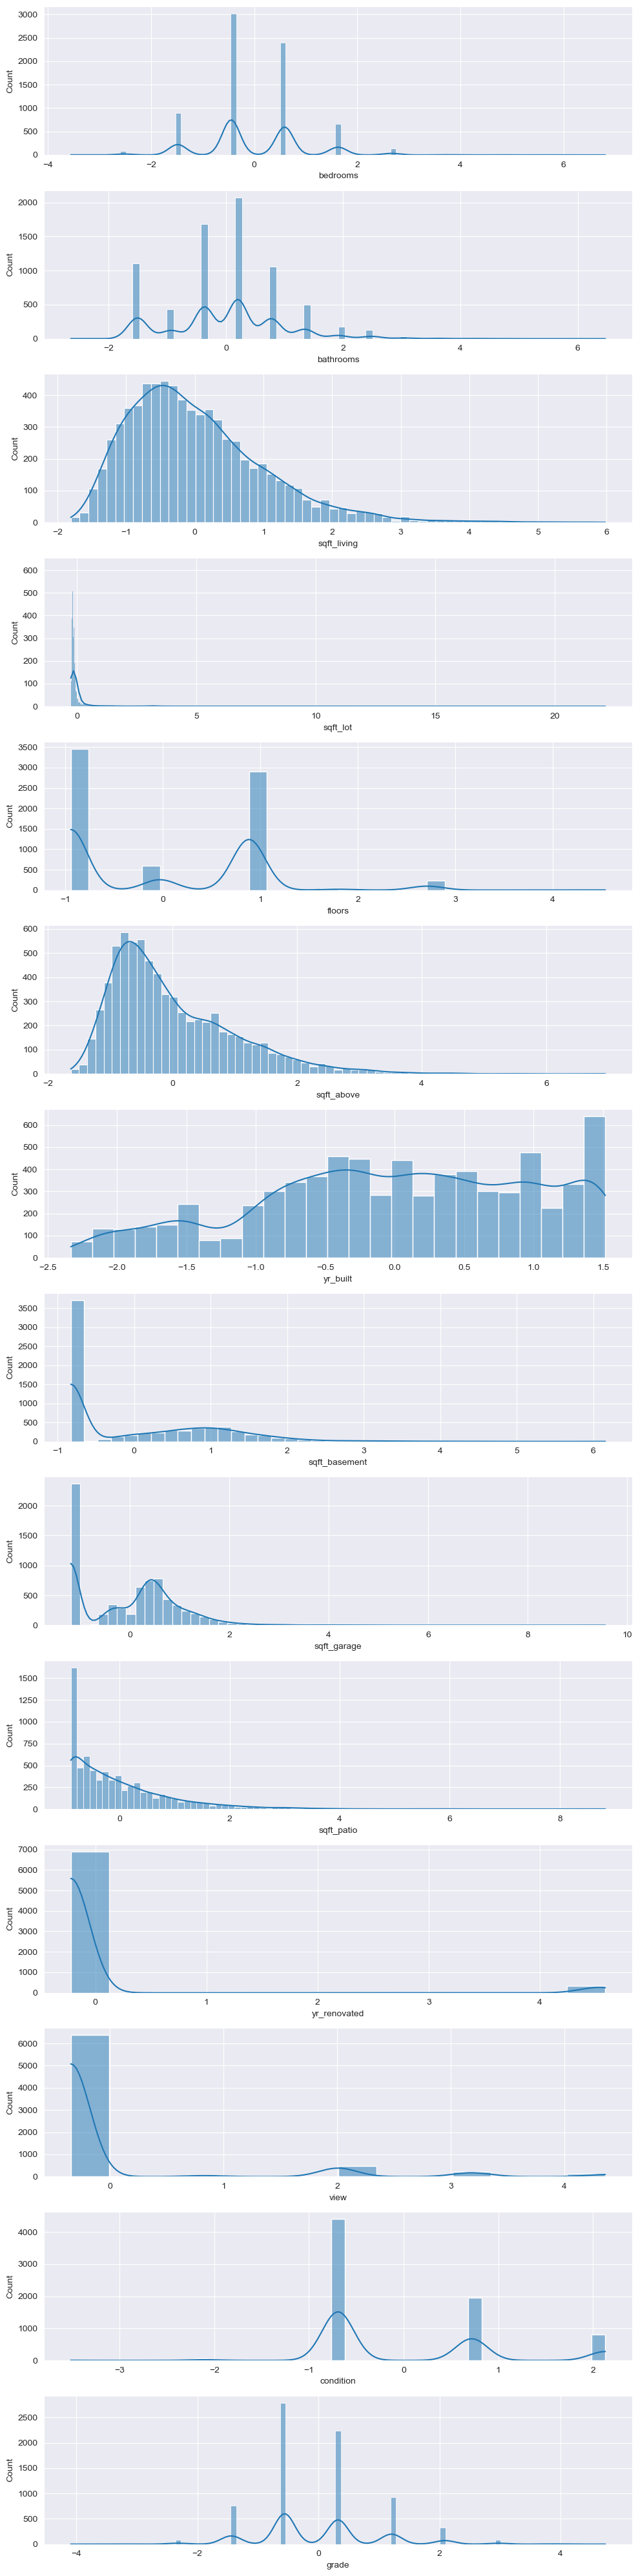

In [63]:
fig, ax = plt.subplots(nrows=len(numeric_cols), figsize=(10,40))
for i,col in enumerate(numeric_cols):
    # sns.scatterplot(x=col,y='price', data=pd.concat([X_train,y_train],1),ax=ax[i])
    sns.histplot(x=col,data=X_test, kde=True,ax=ax[i])
plt.tight_layout()

### Poly Features

In [179]:
# POLYNOIAL FEATURES
# numeric_cols = list(set(X_train.columns.to_list()) - set(['nuisance', 'greenbelt', 'waterfront']))
poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
train_poly = pd.DataFrame(data=poly.fit_transform(X_train[numeric_cols]),
                          index=X_train.index,
                          columns=poly.get_feature_names(numeric_cols))
test_poly = pd.DataFrame(data=poly.transform(X_test[numeric_cols]),
                          index=X_test.index,
                          columns=poly.get_feature_names(numeric_cols))
# model_cols = ['waterfront',
#               'greenbelt',
#               'nuisance',
#               'view',
#               'condition',
#               'grade']
model_cols = ['nuisance', 'greenbelt', 'waterfront']

X_train = X_train[model_cols]
X_train = pd.concat([X_train, train_poly], 1)
X_train = pd.concat([X_train, train_ohe_df], 1)

X_test = X_test[model_cols]
X_test = pd.concat([X_test, test_poly], 1)
X_test = pd.concat([X_test, test_ohe_df], 1)


### PCA

In [1102]:
# PCA features
pca_cols = ['grade',
            'sqft_living',
            'sqft_above',
            'condition',
            'sqft_basement',
            'sqft_patio',
            'bathrooms',
            'yr_built',
            'floors',
            'sqft_garage',
            'bedrooms',
            'sqft_lot']
pca_cols = X_train.columns.to_list()[3:]

pca = PCA(n_components=10)
pca_train_df = pd.DataFrame(pca.fit_transform(X_train[pca_cols]), 
                            columns = [f"pca_{i}" for i in range(pca.n_components_)], 
                            index = X_train.index)
pca_test = pca.transform(X_test[pca_cols])
pca_test_df = pd.DataFrame(pca.transform(X_test[pca_cols]), 
                           columns = [f"pca_{i}" for i in range(pca.n_components_)], 
                           index = X_test.index)

model_cols = list(set(oe_cols + le_cols + numeric_cols) - set(pca_cols))
model_cols = ['nuisance','greenbelt','waterfront']

X_train = X_train[model_cols]
X_train = pd.concat([X_train, train_ohe_df], 1)
X_train = pd.concat([pca_train_df, X_train],1)

X_test = X_test[model_cols]
X_test = pd.concat([X_test, test_ohe_df], 1)
X_test = pd.concat([pca_test_df, X_test],1)



### Regular Features

In [15]:
# regular Features
model_cols = list(set(oe_cols + le_cols + numeric_cols + log_cols))

X_train = X_train[model_cols]
X_train = pd.concat([X_train, train_ohe_df], 1)

X_test = X_test[model_cols]
X_test = pd.concat([X_test, test_ohe_df], 1)


NameError: name 'log_cols' is not defined

## fit model to price

In [185]:
# sklearn
lr = lm.LinearRegression()
lr.fit(X_train,y_train)
print("Train R2:", get_train_score(X_train, y_train))
print("Train Adjusted R2:", get_adjusted_train_score(X_train, y_train))
print_test_scores(X_train, y_train, X_test, y_test)

# statsmodel
model = sm.OLS(y_train,sm.add_constant(X_train))
results = model.fit()
results.summary()

Train R2: 0.7668719672141913
Train Adjusted R2: 0.7644402717888975
         Test R2: 0.7768494803066697
Test Adjusted R2: 0.7768494803066697


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     359.6
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:19:00   Log-Likelihood:            -3.0829e+05
No. Observations:               21733   AIC:                         6.170e+05
Df Residuals:                   21535   BIC:                         6.186e+05
Df Model:                         197                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1.311e+05   7.06e+04      1.858      0.063   -7194.106    2.69e+05
nuisance                   -4.039e+04   6606.778     -6.114      0.000   -5.33e+04   -2.74e+04
greenbelt                   3.161e+04   1.53e+04      2.071      0.038    1698.446    6.15e+04
waterfront                  4.561e+05   2.35e+04     19.393      0.000     4.1e+05    5.02e+05
bedrooms                    1588.4997   3844.438      0.413      0.679   -5946.883    9123.883
bathrooms                   2.163e+04   4901.676      4.413      0.000     1.2e+04    3.12e+04
sqft_living                 9.714e+04   2.24e+04      4.330      0.000    5.32e+04    1.41e+05
sqft_lot                    6.468e+04   5730.501     11.287      0.000    5.34e+04    7.59e+04
floors                     -3.172e+04   5098.855     -6.221      0.000   -4.17e+04   -2.17e+04
sqft_above                  1.204e+05   2.08e+04      5.789      0.000    7.96e+04    1.61e+05
yr_built                    5.368e+04   5720.721      9.384      0.000    4.25e+04    6.49e+04
sqft_basement               6357.1111   9823.167      0.647      0.518   -1.29e+04    2.56e+04
sqft_garage                  1.32e+04   4131.727      3.195      0.001    5102.939    2.13e+04
sqft_patio                  1.557e+04   3676.790      4.234      0.000    8359.130    2.28e+04
yr_renovated               -1.725e+06   2.94e+05     -5.867      0.000    -2.3e+06   -1.15e+06
view                       -2.344e+04   7507.946     -3.123      0.002   -3.82e+04   -8727.546
condition                   5.354e+04   3965.112     13.502      0.000    4.58e+04    6.13e+04
grade                       9.451e+04   4934.849     19.152      0.000    8.48e+04    1.04e+05
bedrooms^2                  -720.0859   2514.976     -0.286      0.775   -5649.625    4209.454
bedrooms bathrooms          9785.2130   5136.235      1.905      0.057    -282.189    1.99e+04
bedrooms sqft_living       -3.014e+04   1.27e+04     -2.367      0.018   -5.51e+04   -5182.333
bedrooms sqft_lot          -7298.0214   3585.339     -2.036      0.042   -1.43e+04    -270.491
bedrooms floors             1634.1959   4572.680      0.357      0.721   -7328.597    1.06e+04
bedrooms sqft_above         1132.8350    1.2e+04      0.095      0.925   -2.23e+04    2.46e+04
bedrooms yr_built           5840.1179   4821.235      1.211      0.226   -3609.859    1.53e+04
bedrooms sqft_basement      5859.8254   6236.281      0.940      0.347   -6363.747    1.81e+04
bedrooms sqft_garage        -323.7422   4363.727     -0.074      0.941   -8876.970    8229.486
bedrooms sqft_patio         1.553e+04   3672.850      4.229      0.000    8332.904    2.27e+04
bedrooms yr_renovated      -2607.0343   3154.607     -0.826      0.409   -8790.297    3576.229
bedrooms view               7583.2490   330

### Mean Error

In [186]:
print("MSE:",metrics.mean_squared_error(y_test, lr.predict(X_test)))
print("RMSE:",metrics.mean_squared_error(y_test, lr.predict(X_test),squared=False) )
print("MAE:",metrics.mean_absolute_error(y_test, lr.predict(X_test)))

MSE: 115255470398.61436
RMSE: 339492.96074972505
MAE: 206831.2552814771


### resid plot

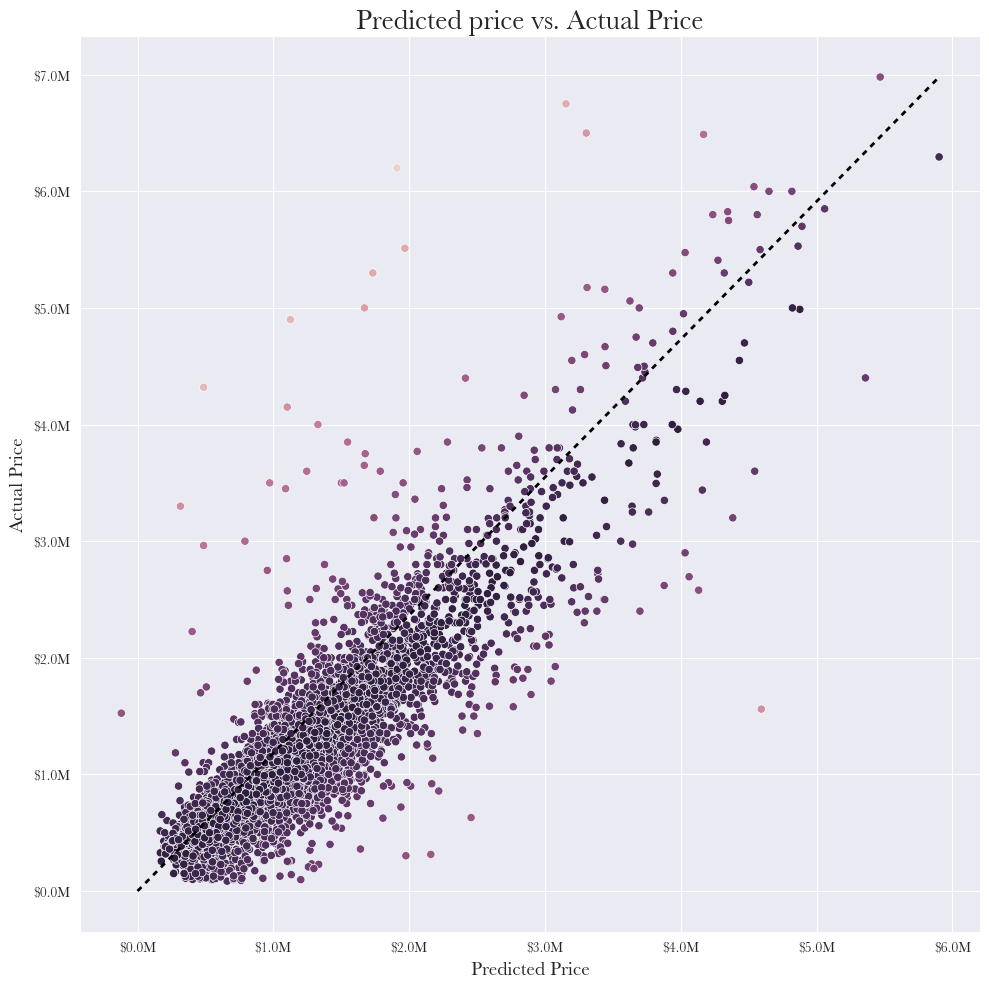

In [203]:
y_hat = lr.predict(X_test)

y_df = pd.DataFrame({'hat':y_hat.flatten()}, index=range(y_hat.shape[0]))
y_df['actual'] = y_test['price'].to_list()
y_df['resid'] = y_df['hat'] - y_df['actual']

fig, ax = plt.subplots(figsize=(10,10))
# sns.jointplot(x= 'actual',y= 'resid', data=y_df).set()
sns.scatterplot(x='hat',y='actual', data=y_df, hue=-np.abs(y_df['resid']))
ax.legend([],[], frameon=False)
plt.xlabel('Predicted Price', fontdict={'fontfamily':'Baskerville',
                                        'fontsize':14,
                                        'fontweight':'bold'})
plt.ylabel('Actual Price', fontdict={'fontfamily':'Baskerville',
                                     'fontsize':14,
                                     'fontweight':'bold'})
plt.title('Predicted price vs. Actual Price', fontdict={'fontfamily':'Baskerville',
                                                        'fontsize':20,
                                                        'fontweight':'bold'})
plt.xticks(fontfamily='Baskerville')
plt.yticks(fontfamily='Baskerville')
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fM' % (x * 1e-6))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
plt.plot([0, y_df['hat'].max()], [0, y_df['actual'].max()], linewidth=2, color='black', dashes=[2,2])
plt.tight_layout()

# plt.savefig('imgs/final_resid.png')
plt.show()

### Top feature coefs_

In [187]:
feat_names = X_train.columns.to_list()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    coefs = pd.DataFrame(columns=['feature','abs_coef_'])
    coefs['abs_coef_'] = pd.Series(np.abs(lr.coef_.flatten())).sort_values(ascending=False)
    coefs['feature'] = [feat_names[i] for i in list(coefs['abs_coef_'].index)]
    display(coefs)

feature     abs_coef_
145                    x0_98039  2.751387e+06
124                    x0_98004  1.857511e+06
13                 yr_renovated  1.725400e+06
146                    x0_98040  1.209822e+06
142                    x0_98033  1.144942e+06
125                    x0_98005  1.132487e+06
173                    x0_98112  9.945925e+05
150                    x0_98050  8.519096e+05
172                    x0_98109  8.180591e+05
128                    x0_98008  8.157879e+05
166                    x0_98102  8.124695e+05
152                    x0_98052  7.937665e+05
126                    x0_98006  7.936152e+05
178                    x0_98119  7.853246e+05
194                    x0_98199  7.837822e+05
127                    x0_98007  7.648375e+05
168                    x0_98105  7.596485e+05
162                    x0_98074  7.175707e+05
163                    x0_98075  6.982629e+05
138                    x0_98029  6.731342e+05
174                    x0_98115  6.607847e+05
170                    x0_98107  6.592895e+05
167                    x0_98103  6.555485e+05
143                    x0_98034  6.500603e+05
179                    x0_98122  6.394744e+05
135                    x0_98024  6.229728e+05
176                    x0_98117  6.204545e+05
153                    x0_98053  6.056612e+05
161                    x0_98072  5.576929e+05
164                    x0_98077  5.549463e+05
184                    x0_98144  5.538792e+05
175                    x0_98116  5.476692e+05
183                    x0_98136  4.948050e+05
190                    x0_98177  4.912704e+05
130                    x0_98011  4.882929e+05
180                    x0_98125  4.601255e+05
136                    x0_98027  4.593812e+05
2                    waterfront  4.560977e+05
187                    x0_98155  4.405504e+05
137                    x0_98028  4.082436e+05
112              yr_renovated^2  4.044198e+05
182                    x0_98133  3.858344e+05
177                    x0_98118  3.731687e+05
181                    x0_98126  3.719881e+05
159                    x0_98065  3.578609e+05
171                    x0_98108  3.349636e+05
185                    x0_98146  2.901757e+05
169                    x0_98106  2.858302e+05
155                    x0_98056  2.839357e+05
158                    x0_98059  2.531233e+05
148                    x0_98045  2.089898e+05
188                    x0_98166  1.984998e+05
132                    x0_98019  1.982171e+05
191                    x0_98178  1.943759e+05
131                    x0_98014  1.723294e+05
189                    x0_98168  1.695779e+05
186                    x0_98148  1.533514e+05
160                    x0_98070  1.439207e+05
156                    x0_98057  1.419657e+05
192                    x0_98188  1.400366e+05
8                    sqft_above  1.203730e+05
154                    x0_98055  1.166522e+05
157                    x0_98058  1.132603e+05
193                    x0_98198  1.023978e+05
5                   sqft_living  9.713604e+04
16                        grade  9.451146e+04
165                    x0_98092  7.543124e+04
144                    x0_98038  7.149475e+04
141                    x0_98032  6.771295e+04
6                      sqft_lot  6.467844e+04
140                    x0_98031  5.951225e+04
195                    x0_98224  5.846795e+04
129                    x0_98010  5.803020e+04
9                      yr_built  5.368461e+04
15                    condition  5.353620e+04
123                    x0_98003  4.868167e+04
149                    x0_98047  4.505865e+04
68            floors sqft_above  4.451812e+04
0                      nuisance  4.039447e+04
122                    x0_98002  4.026728e+04
51       sqft_living sqft_patio  3.991840e+04
133                    x0_98022  3.988343e+04
80       sqft_above sqft_garage  3.770474e+04
55            sqft_living grade  3.724761e+04
118                  view grade  3.611460e+04
35         bathrooms sqft_above  3.527626e+04
44                sqft

### VIF check

In [69]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [VIF(X_train.values, i) for i in range(X_train.shape[1])]
vif_data.sort_values(by='VIF', ascending=False, inplace=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(vif_data)

KeyboardInterrupt: 

### correlations

In [ ]:
corr_df = X_train.corr().abs()
min_corr = .3
top_corrs = pd.DataFrame(columns=['corr','index','col'])
for index in corr_df.index:
    for col in corr_df.columns:
        if corr_df.loc[index,col] > min_corr and corr_df.loc[index,col] != 1:
            top_corrs.loc[top_corrs.shape[0]+1] = [corr_df.loc[index,col], index, col]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    cor = top_corrs.sort_values(by='corr', ascending=False)
    display(cor.iloc[[i*2 for i in range(cor.shape[0]//2)]])
    display(top_corrs.groupby('index').count().sort_values(by='col', ascending=False))
    display(top_corrs.groupby('index').mean().sort_values(by='corr', ascending=False))

corr          index          col
31  0.883045     sqft_above  sqft_living
15  0.775412    sqft_living    bathrooms
61  0.741400          grade  sqft_living
36  0.722444     sqft_above        grade
9   0.678796      bathrooms   sqft_above
60  0.653208          grade    bathrooms
2   0.628351       bedrooms  sqft_living
1   0.595202       bedrooms    bathrooms
34  0.554329     sqft_above  sqft_garage
29  0.535362     sqft_above     bedrooms
39  0.527095       yr_built       floors
65  0.514766          grade  sqft_garage
32  0.508478     sqft_above       floors
20  0.504068    sqft_living  sqft_garage
69  0.500221         x0_Oil       x0_Gas
50  0.498302    sqft_garage     yr_built
43  0.480053       yr_built        grade
28  0.473456         floors        grade
37  0.460917       yr_built    bathrooms
47  0.460836    sqft_garage    bathrooms
8   0.434608      bathrooms       floors
33  0.433137     sqft_above     yr_built
57  0.425773           view   waterfront
53  0.407506     sqft_patio  sqft_living
59  0.389432          grade     bedrooms
16  0.362243    sqft_living       floors
55  0.350481     sqft_patio        grade
70  0.344781      x1_PUBLIC     sqft_lot
38  0.332712       yr_built  sqft_living
52  0.330349     sqft_patio    bathrooms
45  0.326958  sqft_basement  sqft_living
35  0.321786     sqft_above   sqft_patio
44  0.320186       yr_built       x0_Oil
46  0.305938    sqft_garage     bedrooms
42  0.301110       yr_built    condition

corr  col
index                   
sqft_living       9    9
grade             8    8
sqft_above        8    8
bathrooms         8    8
yr_built          8    8
sqft_garage       6    6
floors            5    5
bedrooms          5    5
sqft_patio        4    4
x0_Oil            2    2
condition         1    1
sqft_basement     1    1
sqft_lot          1    1
view              1    1
waterfront        1    1
x0_Gas            1    1
x1_PUBLIC         1    1

corr
index                  
sqft_above     0.579672
sqft_living    0.551300
bathrooms      0.548666
grade          0.540655
x0_Gas         0.500221
bedrooms       0.490857
sqft_garage    0.473040
floors         0.461176
view           0.425773
waterfront     0.425773
yr_built       0.419189
x0_Oil         0.410204
sqft_patio     0.352531
sqft_lot       0.344781
x1_PUBLIC      0.344781
sqft_basement  0.326958
condition      0.301110

## fit model to log(price)

In [156]:
# sklearn
lr = lm.LinearRegression()
lr.fit(X_train,np.log(y_train))
print("Train R2:", get_train_score(X_train, np.log(y_train)))
print("Train Adjusted R2:", get_adjusted_train_score(X_train, np.log(y_train)))
print_test_scores(X_train, np.log(y_train), X_test, np.log(y_test))

# statsmodel
model = sm.OLS(np.log(y_train),sm.add_constant(X_train))
results = model.fit()
results.summary()

Train R2: 0.7400305207072368
Train Adjusted R2: 0.7372025187835207
         Test R2: 0.7583375376986324
Test Adjusted R2: 0.7583375376986324


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     311.2
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:52:41   Log-Likelihood:                -3494.9
No. Observations:               21733   AIC:                             7386.
Df Residuals:                   21535   BIC:                             8967.
Df Model:                         197                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8944      0.057    225.232      0.000      12.782      13.007
nuisance      -0.0392      0.005     -7.321      0.000      -0.050      -0.029
greenbelt      0.0400      0.012      3.233      0.001       0.016       0.064
waterfront     0.2097      0.019     10.990      0.000       0.172       0.247
x0             0.0005      0.003      0.148      0.882      -0.006       0.007
x1             0.0212      0.004      5.325      0.000       0.013       0.029
x2             0.0925      0.018      5.083      0.000       0.057       0.128
x3             0.0675      0.005     14.513      0.000       0.058       0.077
x4            -0.0215      0.004     -5.203      0.000      -0.030      -0.013
x5             0.1111      0.017      6.588      0.000       0.078       0.144
x6             0.0335      0.005      7.214      0.000       0.024       0.043
x7             0.0117      0.008      1.465      0.143      -0.004       0.027
x8             0.0199      0.003      5.929      0.000       0.013       0.026
x9             0.0172      0.003      5.775      0.000       0.011       0.023
x10           -1.6471      0.239     -6.903      0.000      -2.115      -1.179
x11            0.0147      0.006      2.418      0.016       0.003       0.027
x12            0.0511      0.003     15.873      0.000       0.045       0.057
x13            0.0856      0.004     21.381      0.000       0.078       0.093
x0^2           0.0014      0.002      0.687      0.492      -0.003       0.005
x0 x1          0.0096      0.004      2.308      0.021       0.001       0.018
x0 x2         -0.0259      0.010     -2.506      0.012      -0.046      -0.006
x0 x3          0.0042      0.003      1.446      0.148      -0.001       0.010
x0 x4          0.0019      0.004      0.518      0.604      -0.005       0.009
x0 x5          0.0015      0.010      0.152      0.879      -0.018       0.021
x0 x6          0.0079      0.004      2.016      0.044       0.000       0.016
x0 x7          0.0073      0.005      1.437      0.151      -0.003       0.017
x0 x8         -0.0011      0.004     -0.323      0.746      -0.008       0.006
x0 x9          0.0028      0.003      0.954      0.340      -0.003       0.009
x0 x10         0.0005      0.003      0.181      0.857      -0.005       0.005
x0 x11         0.0013      0.003      0.491      0.624      -0.004       0.007
x0 x12         0.0033      0.003      1.110      0.267      -0.003       0.009
x0 x13         0.0058      0.004      1.344      0.179      -0.003       0.014
x1^2          -0.0131      0.003     -3.815      0.000      -0.020      -0.006
x1 x2         -0.0015      0.013     -0.113      0.910      -0.028       0.025
x1 x3         -0.0165      0.005     -3.634      0.000      -0.025      -0.008
x1 x4      -1.589e-05      0.005     -0.003      0.997      -0.010       0.010
x1

### Mean Error log(target)

In [157]:
print("MSE:",metrics.mean_squared_error(y_test, np.exp(lr.predict(X_test))))
print("RMSE:",metrics.mean_squared_error(y_test, np.exp(lr.predict(X_test)),squared=False) )
print("MAE:",metrics.mean_absolute_error(y_test, np.exp(lr.predict(X_test))))

MSE: 115754719934.45175
RMSE: 340227.45323452627
MAE: 190281.8081081853


### resid plot

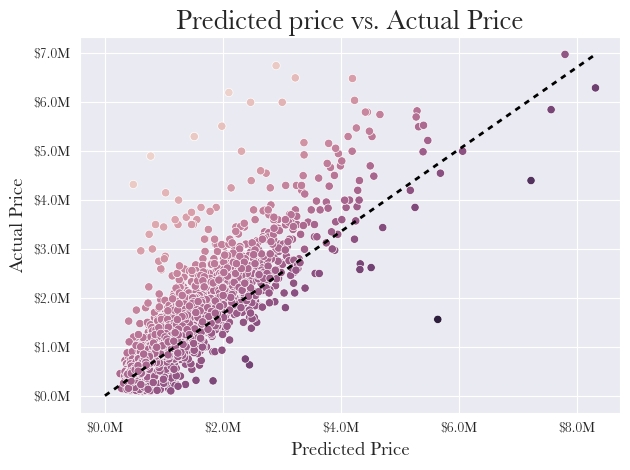

In [150]:
y_hat = np.exp(lr.predict(X_test))

y_df = pd.DataFrame({'hat':y_hat.flatten()}, index=range(y_hat.shape[0]))
y_df['actual'] = y_test['price'].to_list()
y_df['resid'] = y_df['hat'] - y_df['actual']

fig, ax = plt.subplots()
sns.scatterplot(x='hat',y='actual', data=y_df, hue='resid')
ax.legend([],[], frameon=False)
plt.xlabel('Predicted Price', fontdict={'fontfamily':'Baskerville',
                                        'fontsize':14,
                                        'fontweight':'bold'})
plt.ylabel('Actual Price', fontdict={'fontfamily':'Baskerville',
                                     'fontsize':14,
                                     'fontweight':'bold'})
plt.title('Predicted price vs. Actual Price', fontdict={'fontfamily':'Baskerville',
                                                        'fontsize':20,
                                                        'fontweight':'bold'})
plt.xticks(fontfamily='Baskerville')
plt.yticks(fontfamily='Baskerville')
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fM' % (x * 1e-6))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
plt.plot([0, y_df['hat'].max()], [0, y_df['actual'].max()], linewidth=2, color='black', dashes=[2,2])
plt.tight_layout()


plt.show()

### Top feature coefs_

In [184]:
feat_names = X_train.columns.to_list()[:122]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    coefs = pd.DataFrame(columns=['feature','abs_coef_'])
    coefs['abs_coef_'] = pd.Series(np.abs(lr.coef_.flatten())).sort_values(ascending=False)
    coefs['feature'] = [(feat_names[i] if i < 122 else np.nan) for i in list(coefs['abs_coef_'].index)]
    display(coefs)

feature     abs_coef_
145                         NaN  2.751387e+06
124                         NaN  1.857511e+06
13                 yr_renovated  1.725400e+06
146                         NaN  1.209822e+06
142                         NaN  1.144942e+06
125                         NaN  1.132487e+06
173                         NaN  9.945925e+05
150                         NaN  8.519096e+05
172                         NaN  8.180591e+05
128                         NaN  8.157879e+05
166                         NaN  8.124695e+05
152                         NaN  7.937665e+05
126                         NaN  7.936152e+05
178                         NaN  7.853246e+05
194                         NaN  7.837822e+05
127                         NaN  7.648375e+05
168                         NaN  7.596485e+05
162                         NaN  7.175707e+05
163                         NaN  6.982629e+05
138                         NaN  6.731342e+05
174                         NaN  6.607847e+05
170                         NaN  6.592895e+05
167                         NaN  6.555485e+05
143                         NaN  6.500603e+05
179                         NaN  6.394744e+05
135                         NaN  6.229728e+05
176                         NaN  6.204545e+05
153                         NaN  6.056612e+05
161                         NaN  5.576929e+05
164                         NaN  5.549463e+05
184                         NaN  5.538792e+05
175                         NaN  5.476692e+05
183                         NaN  4.948050e+05
190                         NaN  4.912704e+05
130                         NaN  4.882929e+05
180                         NaN  4.601255e+05
136                         NaN  4.593812e+05
2                    waterfront  4.560977e+05
187                         NaN  4.405504e+05
137                         NaN  4.082436e+05
112              yr_renovated^2  4.044198e+05
182                         NaN  3.858344e+05
177                         NaN  3.731687e+05
181                         NaN  3.719881e+05
159                         NaN  3.578609e+05
171                         NaN  3.349636e+05
185                         NaN  2.901757e+05
169                         NaN  2.858302e+05
155                         NaN  2.839357e+05
158                         NaN  2.531233e+05
148                         NaN  2.089898e+05
188                         NaN  1.984998e+05
132                         NaN  1.982171e+05
191                         NaN  1.943759e+05
131                         NaN  1.723294e+05
189                         NaN  1.695779e+05
186                         NaN  1.533514e+05
160                         NaN  1.439207e+05
156                         NaN  1.419657e+05
192                         NaN  1.400366e+05
8                    sqft_above  1.203730e+05
154                         NaN  1.166522e+05
157                         NaN  1.132603e+05
193                         NaN  1.023978e+05
5                   sqft_living  9.713604e+04
16                        grade  9.451146e+04
165                         NaN  7.543124e+04
144                         NaN  7.149475e+04
141                         NaN  6.771295e+04
6                      sqft_lot  6.467844e+04
140                         NaN  5.951225e+04
195                         NaN  5.846795e+04
129                         NaN  5.803020e+04
9                      yr_built  5.368461e+04
15                    condition  5.353620e+04
123                         NaN  4.868167e+04
149                         NaN  4.505865e+04
68            floors sqft_above  4.451812e+04
0                      nuisance  4.039447e+04
122                         NaN  4.026728e+04
51       sqft_living sqft_patio  3.991840e+04
133                         NaN  3.988343e+04
80       sqft_above sqft_garage  3.770474e+04
55            sqft_living grade  3.724761e+04
118                  view grade  3.611460e+04
35         bathrooms sqft_above  3.527626e+04
44                sqft

### VIF check

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [VIF(X_train.values, i) for i in range(X_train.shape[1])]
vif_data.sort_values(by='VIF', ascending=False, inplace=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(vif_data)

feature          VIF
47        x2 x5  2660.165899
44         x2^2  1140.120871
112       x10^2  1049.967765
13          x10  1004.329180
77         x5^2   655.162698
49        x2 x7   397.483843
32        x1 x2   243.081792
55       x2 x13   194.412130
35        x1 x5   176.235235
85       x5 x13   153.382407
79        x5 x7   147.324992
5            x2    82.480136
50        x2 x8    74.986610
80        x5 x8    71.613874
8            x5    69.558206
45        x2 x3    67.430019
46        x2 x4    65.678875
51        x2 x9    59.950398
19        x0 x2    58.823588
58        x3 x5    54.771245
48        x2 x6    54.134769
68        x4 x5    53.761046
78        x5 x6    49.883378
22        x0 x5    44.571772
94         x7^2    43.928405
81        x5 x9    41.066644
53       x2 x11    34.883810
37        x1 x7    26.881650
83       x5 x11    22.985413
54       x2 x12    22.851304
43       x1 x13    21.160346
100      x7 x13    20.466468
52       x2 x10    20.006844
84       x5 x12    19.404144
31         x1^2    17.003422
10           x7    14.747264
121       x13^2    14.244492
82       x5 x10    14.026413
116       x11^2    12.445305
95        x7 x8    11.974968
70        x4 x7    11.725997
18        x0 x1    10.705870
38        x1 x8    10.314426
33        x1 x3    10.143380
106      x8 x13    10.123188
14          x11     9.916115
36        x1 x6     9.577475
66       x3 x13     9.475956
86         x6^2     9.292974
87        x6 x7     9.240647
24        x0 x7     9.013908
96        x7 x9     8.560503
93       x6 x13     8.229700
98       x7 x11     7.788824
56         x3^2     7.693291
69        x4 x6     7.459413
30       x0 x13     7.073088
34        x1 x4     6.916403
88        x6 x8     6.889992
39        x1 x9     6.821572
111      x9 x13     6.007983
41       x1 x11     5.811931
60        x3 x7     5.794212
59        x3 x6     5.770103
76       x4 x13     5.769538
99       x7 x12     5.726187
9            x6     5.705427
90       x6 x10     5.544802
67         x4^2     5.503839
6            x3     5.497128
118     x11 x13     5.231494
23        x0 x6     5.005199
107        x9^2     4.996140
17         x0^2     4.754773
97       x7 x10     4.743086
7            x4     4.476377
101        x8^2     4.456489
16          x13     4.344392
4            x1     4.285387
71        x4 x8     4.243678
42       x1 x12     4.135497
21        x0 x4     4.072336
25        x0 x8     4.056352
92       x6 x12     3.806346
40       x1 x10     3.771343
120     x12 x13     3.756418
61        x3 x8     3.561808
102       x8 x9     3.504164
115     x10 x13     3.234545
57        x3 x4     3.188418
75       x4 x12     3.077650
11           x8     2.992924
62        x3 x9     2.844787
104      x8 x11     2.787565
15          x12     2.748486
91       x6 x11     2.707617
89        x6 x9     2.699650
147    x0_98042     2.652613
119       x12^2     2.631612
20        x0 x3     2.619817
26        x0 x9     2.582484
3            x0     2.579108
167    x0_98103     2.554487
105      x8 x12     2.552983
72        x4 x9     2.514644
109      x9 x11     2.466822
174    x0_98115     2.454936
144    x0_98038     2.439582
176    x0_98117     2.424753
12           x9     2.398014
28       x0 x11     2.353837
73       x4 x10     2.321415
103      x8 x10     2.317377
29       x0 x12     2.302263
27       x0 x10     2.298072
74       x4 x11     2.261270
182    x0_98133     2.183973
143    x0_98034     2.141321
134    x0_98023     2.138638
177    x0_98118     2.094627
157    x0_98058     2.064528
179    x0_98122     2.019400
142    x0_98033     2.014951
165    x0_98092     1.971170
169    x0_98106     1.955814
65       x3 x12     1.954110
152    x0_98052     1.945253
170    x0_98107     1.940247
126    x0_98006     1.924334
158    x0_98059     1.907606
113     x10 x11     1.905569
184    x0_98144     1.894386
187    x0_98155     1.859582
64       x3 x11     1.851579
140    x0_98031     1.844050
155    x0_98056     1.843752
180    x0_98125     1.842063
133   

### correlations

In [ ]:
corr_df = X_train.corr().abs()
min_corr = .3
top_corrs = pd.DataFrame(columns=['corr','index','col'])
for index in corr_df.index:
    for col in corr_df.columns:
        if corr_df.loc[index,col] > min_corr and corr_df.loc[index,col] != 1:
            top_corrs.loc[top_corrs.shape[0]+1] = [corr_df.loc[index,col], index, col]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    cor = top_corrs.sort_values(by='corr', ascending=False)
    display(cor.iloc[[i*2 for i in range(cor.shape[0]//2)]])
    display(top_corrs.groupby('index').count().sort_values(by='col', ascending=False))
    display(top_corrs.groupby('index').mean().sort_values(by='corr', ascending=False))

corr          index          col
31  0.883045     sqft_above  sqft_living
15  0.775412    sqft_living    bathrooms
61  0.741400          grade  sqft_living
36  0.722444     sqft_above        grade
9   0.678796      bathrooms   sqft_above
60  0.653208          grade    bathrooms
2   0.628351       bedrooms  sqft_living
1   0.595202       bedrooms    bathrooms
34  0.554329     sqft_above  sqft_garage
29  0.535362     sqft_above     bedrooms
39  0.527095       yr_built       floors
65  0.514766          grade  sqft_garage
32  0.508478     sqft_above       floors
20  0.504068    sqft_living  sqft_garage
69  0.500221         x0_Oil       x0_Gas
50  0.498302    sqft_garage     yr_built
43  0.480053       yr_built        grade
28  0.473456         floors        grade
37  0.460917       yr_built    bathrooms
47  0.460836    sqft_garage    bathrooms
8   0.434608      bathrooms       floors
33  0.433137     sqft_above     yr_built
57  0.425773           view   waterfront
53  0.407506     sqft_patio  sqft_living
59  0.389432          grade     bedrooms
16  0.362243    sqft_living       floors
55  0.350481     sqft_patio        grade
70  0.344781      x1_PUBLIC     sqft_lot
38  0.332712       yr_built  sqft_living
52  0.330349     sqft_patio    bathrooms
45  0.326958  sqft_basement  sqft_living
35  0.321786     sqft_above   sqft_patio
44  0.320186       yr_built       x0_Oil
46  0.305938    sqft_garage     bedrooms
42  0.301110       yr_built    condition

corr  col
index                   
sqft_living       9    9
grade             8    8
sqft_above        8    8
bathrooms         8    8
yr_built          8    8
sqft_garage       6    6
floors            5    5
bedrooms          5    5
sqft_patio        4    4
x0_Oil            2    2
condition         1    1
sqft_basement     1    1
sqft_lot          1    1
view              1    1
waterfront        1    1
x0_Gas            1    1
x1_PUBLIC         1    1

corr
index                  
sqft_above     0.579672
sqft_living    0.551300
bathrooms      0.548666
grade          0.540655
x0_Gas         0.500221
bedrooms       0.490857
sqft_garage    0.473040
floors         0.461176
view           0.425773
waterfront     0.425773
yr_built       0.419189
x0_Oil         0.410204
sqft_patio     0.352531
sqft_lot       0.344781
x1_PUBLIC      0.344781
sqft_basement  0.326958
condition      0.301110